# Interactive Recipe & Kitchen Management Assistant


## Project Overview

The Interactive Recipe & Kitchen Management Assistant helps users:
1. Discover recipes based on available ingredients
2. Customize recipes according to dietary needs
3. Receive step-by-step cooking guidance

This assistant will use multiple Gen AI capabilities including:
- Audio understanding (for voice input)
- Few-shot prompting (for recipe customization)
- Function calling (for specific recipe operations)
- RAG (Retrieval Augmented Generation for recipe knowledge)
- Grounding (using web search for supplemental information)


## "Good code is like a good joke – it needs no explanation."
— Gregor Hohpe

- However... since we're still leveling up, I'll add a few helpful comments along the way.
- Because even the best jokes need subtitles when you're just getting started! 😅


## Step 1: Data Source & Setup

This notebook implements the first step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll acquire, explore, and prepare the recipe dataset that will serve as the foundation for our recipe retrieval and customization system.


## Setup Environment

Let's start by installing and importing the necessary libraries for data processing.

In [1]:
# Clean up and install compatible versions
#!pip uninstall -y tensorflow protobuf google-api-core google-cloud-automl google-generativeai google-cloud-translate chromadb
!pip uninstall -qqy kfp > /dev/null 2>&1

# Install chromadb with compatible versions
!pip install -qU --no-warn-conflicts "google-genai==1.7.0" chromadb==0.6.3 
# #!pip install -U google-api-core==2.16.0

!pip install -q --no-warn-conflicts google-cloud-speech

# Install base packages with minimal dependencies
!pip install -q --no-warn-conflicts pandas matplotlib seaborn 
!pip install -q --no-warn-conflicts kagglehub[pandas-datasets]
!pip install -q --no-warn-conflicts soundfile pydub ipywidgets openai

# Install compatible versions
#!pip install -q google-generativeai  # Latest version instead of 1.7.0




## Import Libraries

Now let's import the libraries we'll need for this step.

In [90]:
# ===============================
# 📦 Standard Library Imports
# ===============================
import contextlib
import datetime
import io
import os
import random
import re
import sqlite3
import sys
import tempfile
import time
import warnings
from collections import Counter, defaultdict
from pathlib import Path
from typing import Annotated, Any, Dict, List, Literal, Optional, Sequence, Tuple
import contextlib
from io import StringIO
# ===============================
# 📊 Data Analysis & Visualization
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 🌐 Networking & APIs
# ===============================
import requests
import json

# ===============================
# 🧠 Widgets & Interactive Display
# ===============================
import ipywidgets as widgets
from IPython.display import Audio, Image, Markdown, clear_output, display, HTML

# ===============================
# 🔍 ChromaDB Vector DB
# ===============================
import chromadb
from chromadb.config import Settings
from chromadb.utils import embedding_functions

# ===============================
# 💬 LangChain / LangGraph
# ===============================
from langchain_core.messages import (
    AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage
)
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from typing_extensions import TypedDict

# ===============================
# 🤖 Google Gemini & Speech APIs
# ===============================
from google import genai
from google.api_core import retry
from google.genai import types

# Retry mechanism for Gemini API
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(predicate=is_retriable)(
    genai.models.Models.generate_content
)

# ===============================
# 🎤 Audio Processing (Optional)
# ===============================
try:
    import soundfile as sf
    import sounddevice as sd
    AUDIO_LIBRARIES_AVAILABLE = True
    print("Audio libraries imported successfully!")
except (ImportError, OSError) as e:
    AUDIO_LIBRARIES_AVAILABLE = False
    print(f"Warning: Audio libraries could not be imported: {e}")

# ===============================
# 🗣️ Google Cloud Speech-to-Text (Optional)
# ===============================
try:
    from google.cloud import speech
    GOOGLE_SPEECH_AVAILABLE = True
    print("Google Cloud Speech-to-Text is imported successfully!")
except ImportError:
    GOOGLE_SPEECH_AVAILABLE = False
    print("Google Cloud Speech-to-Text not available. Will use simulation for speech recognition.")

# ===============================
# 🎨 Visualization & Display Setup
# ===============================
plt.style.use('ggplot')
sns.set(style="whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

print("Environment setup complete!")
print("Google Gemini version:", genai.__version__)


Google Cloud Speech-to-Text is imported successfully!
Environment setup complete!
Google Gemini version: 1.7.0


In [2]:
# Define paths for ChromaDB and SQL database
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"


In [3]:
import sys
import os

# Check Python paths
print("Python path:")
for path in sys.path:
    print(path)

# Try to find chromadb
try:
    import chromadb
    print(f"\nchromadb imported as: {type(chromadb)}")
    print(f"chromadb location: {chromadb.__file__}")
except Exception as e:
    print(f"\nError importing chromadb: {e}")

Python path:
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/snowholt/venv/analytic/lib/python3.12/site-packages

chromadb imported as: <class 'module'>
chromadb location: /home/snowholt/venv/analytic/lib/python3.12/site-packages/chromadb/__init__.py


### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`, `GOOGLE_APPLICATION_CREDENTIALS`, `OPENAI_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

Furthermore, for the Google Cloud Client Libraries (like the google-cloud-speech Python library you're using), you generally cannot authenticate using only an API Key. 🚫🔑, So you need to provide and import Service Account Credentials (JSON Key File).

In [4]:
# from kaggle_secrets import UserSecretsClient

# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# OPENAI_API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")
# SecretValueJson = UserSecretsClient().get_secret("GOOGLE_APPLICATION_CREDENTIALS") # Use the label you gave the secret
# USDA_API_KEY = UserSecretsClient().get_secret("OPENFOODFACTS_API_KEY")


In [63]:
# Import the os module to access environment variables

# In cell 1cef5527...

# Import the os module to access environment variables
import os


# --- Function to retrieve keys (optional verification) ---
def get_api_key(key_name):
    """
    Retrieve an API key from environment variables.
    """
    api_key = os.environ.get(key_name)
    if api_key is None:
        print(f"Warning: {key_name} environment variable not found.")
    return api_key

# Example verification
GOOGLE_API_KEY= get_api_key("GOOGLE_API_KEY")
SecretValueJson = get_api_key("GOOGLE_APPLICATION_CREDENTIALS")
USDA_API_KEY = get_api_key("OPENFOODFACTS_API_KEY")
OPENAI_API_KEY = get_api_key("OPENAI_API_KEY")

print(f"Google API Key exists: {GOOGLE_API_KEY is not None}")
print(f"SecretValueJson Path exists: {SecretValueJson is not None}")
print(f"USDA API Key exists: {USDA_API_KEY is not None}")
print(f"OpenAI API Key exists: {OPENAI_API_KEY is not None}")

Google API Key exists: True
SecretValueJson Path exists: True
USDA API Key exists: True
OpenAI API Key exists: True



## Data Loading

### Importing the Dataset in Kaggle

Since you're using Kaggle, you can easily import the Food.com Recipes dataset directly:

1. Search for "Food.com Recipes and User Interactions" in the Kaggle datasets section
2. Or use this direct link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In Kaggle, you can either:
- Add the dataset to your notebook directly from the "Add data" button in the right sidebar
- Use the Kaggle datasets API as shown below


We'll use the Food.com Recipes and Interactions dataset. This contains recipe information including ingredients, steps, and user interactions.

If you've downloaded the dataset using the Kaggle API, uncomment and use the data loading code below. Otherwise, we'll use a direct URL to access the data.

loading both the vectorized and raw data and nutritional breakdown dataset that will be used in subsequent steps, particularly for the few-shot prompting recipe customization implementation.

In [6]:
# Option 1: Direct Kaggle dataset import
# This is the easiest way to import datasets in Kaggle notebooks

try:
    # If the dataset is added via the "Add data" button, it will be available at /kaggle/input/
    recipes_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_recipes.csv')
    interactions_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_interactions.csv')
    nutrition_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/cleaned_nutrition_dataset.csv')
    print(f"Successfully loaded {len(recipes_df)} recipes")
    print(f"Successfully loaded {len(interactions_df)} interactions")
    print(f"Successfully loaded nutritional dataset with {len(nutrition_df)} records")

    
    
    
except FileNotFoundError:
    print("Dataset files not found. Please make sure you've added the dataset to your Kaggle notebook.")
    print("You can add it by clicking the 'Add data' button in the right sidebar.")
    print("Alternatively, you can use direct URLs if available.")

# Let's parse the JSON strings in the columns that contain lists
if 'recipes_df' in locals():
    # Check the actual structure of the dataframe
    
    # For Food.com dataset, ingredients, steps, and tags are stored as strings that represent lists
    # We need to convert them from string representation to actual Python lists
    try:
        if 'ingredients' in recipes_df.columns:
            recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)
            print("Successfully parsed ingredients column")
        
        if 'steps' in recipes_df.columns:
            recipes_df['steps'] = recipes_df['steps'].apply(eval)
            print("Successfully parsed steps column")
        
        if 'tags' in recipes_df.columns:
            recipes_df['tags'] = recipes_df['tags'].apply(eval)
            print("Successfully parsed tags column")
            
            # Add cuisine type based on tags
            recipes_df['cuisine_type'] = recipes_df['tags'].apply(
                lambda x: next((tag for tag in x if tag in ['italian', 'persian', 'mexican', 'chinese', 'indian', 'french', 'thai']), 'other')
            )
        
      
        # Count number of ingredients
        recipes_df['n_ingredients'] = recipes_df['ingredients'].apply(len)
            
        print("\nDataset successfully processed")
        
    except Exception as e:
        print(f"Error processing dataset: {e}")
        print("Column sample values:")
        for col in recipes_df.columns:
            print(f"{col}: {recipes_df[col].iloc[0]}")



Successfully loaded 231637 recipes
Successfully loaded 1132367 interactions
Successfully loaded nutritional dataset with 3454 records
Successfully parsed ingredients column
Successfully parsed steps column
Successfully parsed tags column

Dataset successfully processed


## Data Exploration

Let's explore the dataset to understand its structure and content. This will help us plan our cleaning and preprocessing steps.

In [7]:

# Function to analyze dataframe properties
def analyze_dataframe(df, df_name):
    print(f"\n{'-' * 30}")
    print(f"Analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # Check data types
    print("\nData types:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")
    
    # Check missing values
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    for col, missing in zip(missing_values.index, missing_values.values):
        if missing > 0:
            print(f"{col}: {missing} missing values ({missing/len(df):.2%})")
    
    # Summary statistics for numeric columns
    print("\nNumeric columns summary:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numeric_cols:
        # Show basic stats for numeric columns only
        print(df[numeric_cols].describe().T[['count', 'mean', 'min', 'max']])
    else:
        print("No numeric columns found")

# Analyze all dataframes
print("\n=== DATA ANALYSIS FOR ALL DATAFRAMES ===")
analyze_dataframe(recipes_df, "Recipes")
analyze_dataframe(interactions_df, "Interactions")
analyze_dataframe(nutrition_df, "Nutrition")






=== DATA ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Analysis for Recipes:
------------------------------

Data types:
name: object
id: int64
minutes: int64
contributor_id: int64
submitted: object
tags: object
nutrition: object
n_steps: int64
steps: object
description: object
ingredients: object
n_ingredients: int64
cuisine_type: object

Missing values per column:
name: 1 missing values (0.00%)
description: 4979 missing values (2.15%)

Numeric columns summary:
                   count          mean   min           max
id              231637.0  2.220147e+05  38.0  5.377160e+05
minutes         231637.0  9.398546e+03   0.0  2.147484e+09
contributor_id  231637.0  5.534885e+06  27.0  2.002290e+09
n_steps         231637.0  9.765499e+00   0.0  1.450000e+02
n_ingredients   231637.0  9.051153e+00   1.0  4.300000e+01

------------------------------
Analysis for Interactions:
------------------------------

Data types:
user_id: int64
recipe_id: int64
date: object
rating: int6

In [8]:
# Sample a few rows instead of full stats
print("\nSample rows:")
print(recipes_df.sample(3))


Sample rows:
                            name      id  minutes  contributor_id   submitted  \
44758          chicken margarita  288238      200          143001  2008-02-23   
201959      stuffed cornish hens  393972       85          226863  2009-10-11   
147118  old kentucky beer cheese   90698       20           10113  2004-05-05   

                                                                                                       tags  \
44758   [time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, main-dis...   
201959  [time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, main-dis...   
147118  [30-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, for-large-gro...   

                                          nutrition  n_steps  \
44758   [773.8, 104.0, 29.0, 29.0, 62.0, 57.0, 3.0]        9   
201959  [420.2, 28.0, 15.0, 49.0, 101.0, 33.0, 3.0]       12   
147118    [253.2, 30.0, 

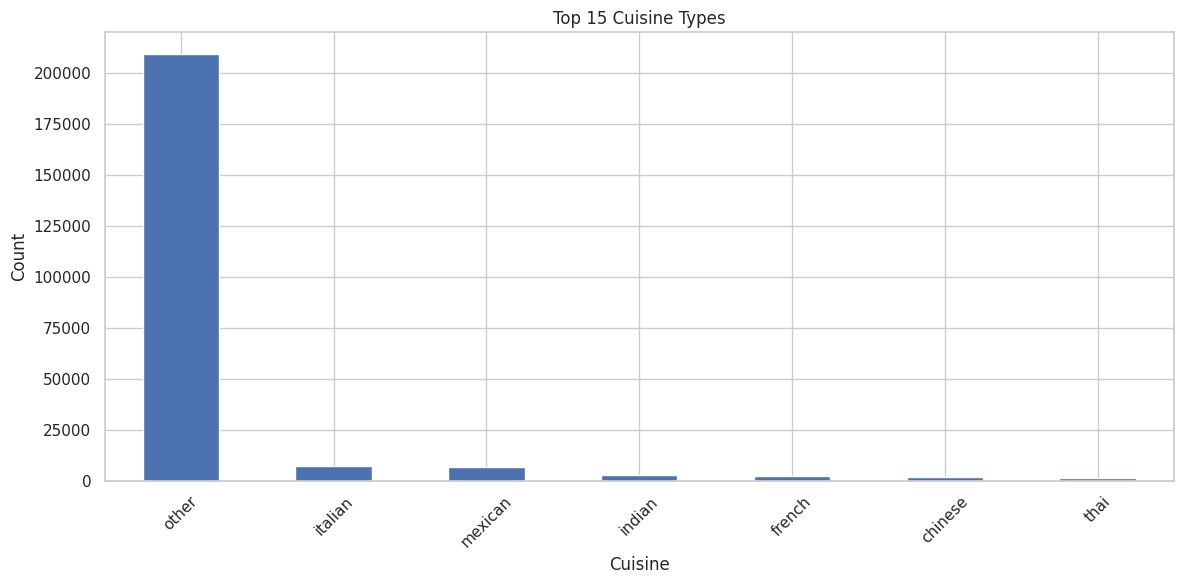

In [9]:
# # Distribution of cuisine types
plt.figure(figsize=(12, 6))
if 'cuisine_type' in recipes_df.columns:
    # Limit to top 15 cuisines to avoid cluttered plot
    recipes_df['cuisine_type'].value_counts().nlargest(15).plot(kind='bar')
    plt.title('Top 15 Cuisine Types')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [10]:
# # Distribution of cooking time - use smaller bins
# if 'cooking_time' in recipes_df.columns:
#     plt.figure(figsize=(10, 6))
#     # Use log scale for better visualization if the range is large
#     if recipes_df['cooking_time'].max() > 5 * recipes_df['cooking_time'].median():
#         sns.histplot(recipes_df['cooking_time'].clip(upper=recipes_df['cooking_time'].quantile(0.95)), bins=20)
#         plt.title('Distribution of Cooking Time (minutes) - Clipped at 95th percentile')
#     else:
#         sns.histplot(recipes_df['cooking_time'], bins=20)
#         plt.title('Distribution of Cooking Time (minutes)')
#     plt.xlabel('Cooking Time (minutes)')
#     plt.ylabel('Count')
#     plt.tight_layout()
#     plt.show()

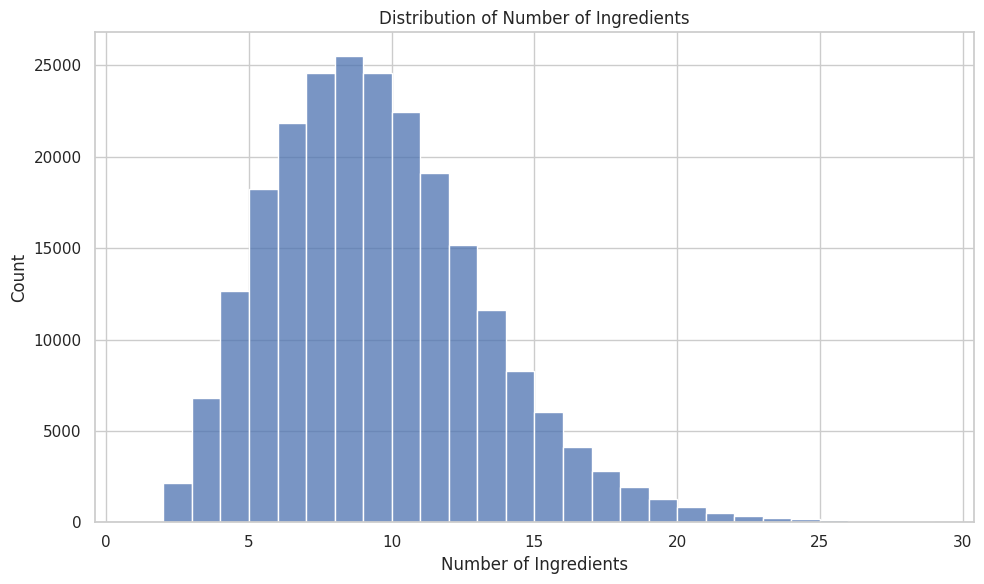

In [11]:
# Number of ingredients distribution
if 'n_ingredients' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(recipes_df['n_ingredients'], bins=range(1, min(30, recipes_df['n_ingredients'].max()+1)))
    plt.title('Distribution of Number of Ingredients')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Data Cleaning and Preprocessing

Now we'll clean the data by:
1. Removing duplicate recipes
2. Normalizing ingredient names
3. Standardizing measurements
4. Handling missing values
5. Creating dietary tags

In [12]:

# Function to check and remove duplicates in dataframes
def check_remove_duplicates(df, df_name, subset_cols=None):
    """
    Check and remove duplicates from a dataframe.
    
    Args:
        df: The dataframe to process
        df_name: Name of the dataframe for printing
        subset_cols: List of columns to consider for duplicates. If None, all columns are used.
    
    Returns:
        Dataframe with duplicates removed
    """
    print(f"\n{'-' * 30}")
    print(f"Duplicate analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # If subset not specified, identify potential key columns
    if subset_cols is None:
        # Try to find ID-like columns first
        id_cols = [col for col in df.columns if 'id' in col.lower()]
        name_cols = [col for col in df.columns if 'name' in col.lower()]
        
        if id_cols:
            subset_cols = id_cols
            print(f"Using ID columns for duplicate check: {subset_cols}")
        elif name_cols:
            subset_cols = name_cols
            print(f"Using name columns for duplicate check: {subset_cols}")
        else:
            # Use all columns if no suitable identifiers found
            subset_cols = df.columns.tolist()
            print("Using all columns for duplicate check")
    
    # Check for duplicates
    dup_count = df.duplicated(subset=subset_cols).sum()
    print(f"Number of duplicates in {df_name}: {dup_count} ({dup_count/len(df):.2%} of data)")
    
    if dup_count > 0:
        # Remove duplicates
        df_cleaned = df.drop_duplicates(subset=subset_cols).reset_index(drop=True)
        print(f"Number of records after removing duplicates: {len(df_cleaned)}")
        return df_cleaned
    else:
        print("No duplicates found")
        return df


In [13]:
# Check and remove duplicates from all dataframes
print("\n=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===")
recipes_df = check_remove_duplicates(recipes_df, "Recipes", subset_cols=['name'])
interactions_df = check_remove_duplicates(interactions_df, "Interactions")
nutrition_df = check_remove_duplicates(nutrition_df, "Nutrition")



=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Duplicate analysis for Recipes:
------------------------------
Number of duplicates in Recipes: 1451 (0.63% of data)
Number of records after removing duplicates: 230186

------------------------------
Duplicate analysis for Interactions:
------------------------------
Using ID columns for duplicate check: ['user_id', 'recipe_id']
Number of duplicates in Interactions: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Nutrition:
------------------------------
Using all columns for duplicate check
Number of duplicates in Nutrition: 0 (0.00% of data)
No duplicates found


In [14]:

# Function to normalize ingredient names
def normalize_ingredients(ingredient_list):
    """
    Normalize ingredient names by removing quantities and standardizing format
    """
    normalized = []
    # If ingredient_list is already a list of strings
    if isinstance(ingredient_list, list):
        for ingredient in ingredient_list:
            # Skip empty ingredients
            if not ingredient or not isinstance(ingredient, str):
                continue
            
            # Remove quantities (simplified for demonstration)
            cleaned = re.sub(r'^\d+\s+\d+/\d+\s+', '', ingredient)
            cleaned = re.sub(r'^\d+/\d+\s+', '', cleaned)
            cleaned = re.sub(r'^\d+\s+', '', cleaned)
            
            # Convert to lowercase and strip whitespace
            cleaned = cleaned.lower().strip()
            
            normalized.append(cleaned)
    else:
        # Handle the case where ingredient_list might be a string or another format
        print("Warning: Expected ingredient_list to be a list, but got:", type(ingredient_list))
        if isinstance(ingredient_list, str):
            # Try to interpret as a string representation of a list
            try:
                actual_list = eval(ingredient_list) if ingredient_list.startswith('[') else [ingredient_list]
                return normalize_ingredients(actual_list)
            except:
                normalized = [ingredient_list.lower().strip()]
    
    return normalized

# Apply normalization to ingredients - with error handling
recipes_df['normalized_ingredients'] = recipes_df['ingredients'].apply(
    lambda x: normalize_ingredients(x) if isinstance(x, list) or isinstance(x, str) else []
)

# Show a sample recipe with normalized ingredients
if len(recipes_df) > 0:
    sample_idx = 0
    print(f"Original ingredients: {recipes_df.iloc[sample_idx]['ingredients']}")
    print(f"Normalized ingredients: {recipes_df.iloc[sample_idx]['normalized_ingredients']}")
else:
    print("No recipes found in the dataframe.")

Original ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Normalized ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


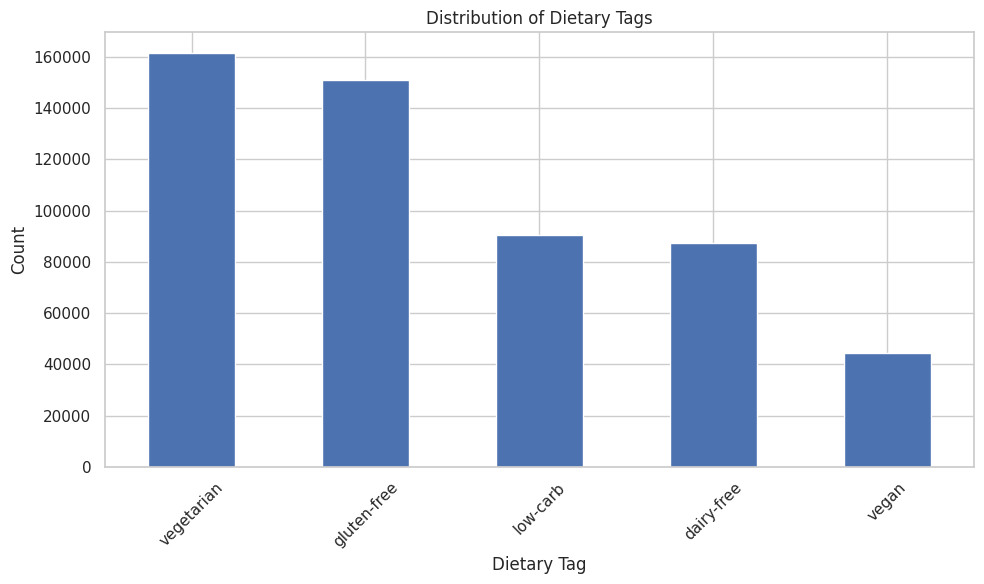


Sample recipes with dietary tags:

Recipe: chicken picquant
Ingredients: boneless chicken breasts, flour, oil, celery, green pepper, onion, tomatoes, jalapeno pepper, chicken broth, butter, garlic, tabasco sauce, cayenne pepper, white pepper
Dietary Tags: None

Recipe: mediterranean roasted vegetables with herbs
Ingredients: eggplant, zucchini, onions, carrots, sun-dried tomatoes, summer squash, red bell pepper, celery rib, fresh green beans, pitted black olives, fresh basil leaf, marjoram leaves, fresh rosemary, fresh thyme, olive oil, salt, fresh ground black pepper, garlic, grape tomatoes
Dietary Tags: vegetarian, gluten-free, low-carb, dairy-free

Recipe: yummy cobblestone brownies
Ingredients: brownie mix, canola oil, eggs, coconut extract, cream cheese, vanilla extract, confectioners' sugar, flaked coconut
Dietary Tags: vegetarian, gluten-free

Recipe: lamb  spinach  feta burgers
Ingredients: ground lamb, frozen chopped spinach, onion, garlic, breadcrumbs, egg, feta cheese, parm

In [15]:
# Function to identify dietary tags based on ingredients
def identify_dietary_tags(ingredients):
    """
    Identify dietary preferences based on ingredients
    """
    # Handle empty ingredients list
    if not ingredients or not isinstance(ingredients, (list, str)):
        return []
        
    # Convert list of ingredients to a single string for easier checking
    ingredients_str = ' '.join(ingredients).lower()
    
    tags = []
    
    # Vegetarian check (simplified)
    meat_ingredients = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'veal', 'bacon']
    if not any(meat in ingredients_str for meat in meat_ingredients):
        tags.append('vegetarian')
        
        # Vegan check (simplified)
        animal_products = ['cheese', 'milk', 'cream', 'yogurt', 'butter', 'egg', 'honey']
        if not any(product in ingredients_str for product in animal_products):
            tags.append('vegan')
    
    # Gluten-free check (simplified)
    gluten_ingredients = ['flour', 'wheat', 'barley', 'rye', 'pasta', 'bread']
    if not any(gluten in ingredients_str for gluten in gluten_ingredients):
        tags.append('gluten-free')
    
    # Low-carb check (simplified)
    high_carb_ingredients = ['sugar', 'pasta', 'rice', 'potato', 'bread', 'flour']
    if not any(carb in ingredients_str for carb in high_carb_ingredients):
        tags.append('low-carb')
    
    # Dairy-free check
    dairy_ingredients = ['milk', 'cheese', 'cream', 'yogurt', 'butter']
    if not any(dairy in ingredients_str for dairy in dairy_ingredients):
        tags.append('dairy-free')
    
    return tags

# Apply dietary tagging
recipes_df['dietary_tags'] = recipes_df['normalized_ingredients'].apply(identify_dietary_tags)

# Show the distribution of dietary tags
diet_counts = {}
for tags in recipes_df['dietary_tags']:
    for tag in tags:
        diet_counts[tag] = diet_counts.get(tag, 0) + 1

plt.figure(figsize=(10, 6))
diet_df = pd.Series(diet_counts).sort_values(ascending=False)
diet_df.plot(kind='bar')
plt.title('Distribution of Dietary Tags')
plt.xlabel('Dietary Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample recipes with their dietary tags
print("\nSample recipes with dietary tags:")
sample_recipes = recipes_df[['name', 'normalized_ingredients', 'dietary_tags']].sample(5)
for _, recipe in sample_recipes.iterrows():
    print(f"\nRecipe: {recipe['name']}")
    print(f"Ingredients: {', '.join(recipe['normalized_ingredients'])}")
    print(f"Dietary Tags: {', '.join(recipe['dietary_tags']) if recipe['dietary_tags'] else 'None'}")

In [16]:

# Basic dataset information
print("Raw Datasets information:")
print(f"Number of recipes: {len(recipes_df)}")
print("\nrecipes_df columns:")
print(recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of interactions: {len(interactions_df)}")
print("\ninteractions_df columns:")
print(interactions_df.columns.tolist())
print(15 * "-")
print(f"Number of nutritions: {len(nutrition_df)}")
print("\nnutrition_df columns:")
print(nutrition_df.columns.tolist())
print(15 * "-")


Raw Datasets information:
Number of recipes: 230186

recipes_df columns:
['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type', 'normalized_ingredients', 'dietary_tags']
---------------
Number of interactions: 1132367

interactions_df columns:
['user_id', 'recipe_id', 'date', 'rating', 'review']
---------------
Number of nutritions: 3454

nutrition_df columns:
['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium', 'Carbohydrates', 'food', 'Iron', 'Caloric Value', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein', 'food_normalized']
---------------


## Final Data Structure and Storage

### Save Datasets in JSON Format for RAG Implementation

Let's save each dataset in JSON format to facilitate their use in our Retrieval Augmented Generation (RAG) system. JSON format is highly compatible with various RAG implementations and will make it easier to load the data in subsequent steps.

In [17]:
import chromadb
print(chromadb.__version__)


0.6.3


In [18]:


# Define paths for ChromaDB and SQL database
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"

#####################
# SQL Database Setup
#####################
def safe_convert(x):
    """
    Safely converts a value to a string:
      - If x is a list or numpy array, join its elements into a space-separated string.
      - If x is not a list/array and is not null, convert to string.
      - Otherwise, return an empty string.
    """
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""


def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess DataFrame columns to be SQLite-compatible.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(safe_convert)
    return df

def setup_sql_database(
    recipes_df: pd.DataFrame, 
    interactions_df: pd.DataFrame, 
    nutrition_df: Optional[pd.DataFrame] = None,
    db_path: str = DB_PATH
) -> sqlite3.Connection:
    """
    Set up SQLite database with raw dataframes.
    """
    recipes_df = preprocess_dataframe(recipes_df)
    interactions_df = preprocess_dataframe(interactions_df)
    if nutrition_df is not None:
        nutrition_df = preprocess_dataframe(nutrition_df)

    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    print(f"Creating SQLite database at {db_path}")
    conn = sqlite3.connect(db_path)
    
    print(f"Storing {len(recipes_df)} recipes in the database")
    recipes_df.to_sql('recipes', conn, if_exists='replace', index=False)
    print(f"Storing {len(interactions_df)} interactions in the database")
    interactions_df.to_sql('interactions', conn, if_exists='replace', index=False)
    
    if nutrition_df is not None:
        print(f"Storing {len(nutrition_df)} nutrition entries in the database")
        nutrition_df.to_sql('nutrition', conn, if_exists='replace', index=False)
    
    print("SQL database setup complete")
    return conn

#############################
# Vector Database Setup (ChromaDB)
#############################
def setup_vector_database(
    vectorized_recipes_df: pd.DataFrame,
    vectorized_interactions_df: Optional[pd.DataFrame] = None,
    vector_db_path: str = VECTOR_DB_PATH
) -> Tuple[Any, Any, Optional[Any]]:
    """
    Set up ChromaDB using the precomputed dataframes for recipes and interactions.
    
    Arguments:
        vectorized_recipes_df: DataFrame with your recipe data.
        vectorized_interactions_df: DataFrame with your interaction data.
        vector_db_path: Directory where ChromaDB will store its data.
        
    Returns:
        A tuple containing the ChromaDB client, the recipe collection, and 
        the interactions collection (if interactions_df is provided).
    """
    os.makedirs(vector_db_path, exist_ok=True)
    print(f"Creating ChromaDB at {vector_db_path}")
    client = chromadb.PersistentClient(path=vector_db_path)
    
    #########################
    # Load recipes into ChromaDB
    #########################
    print(f"Setting up recipe collection with {len(vectorized_recipes_df)} recipes")
    recipe_collection = client.get_or_create_collection(name="recipes")
    
    recipe_documents = []
    recipe_metadatas = []
    recipe_ids = []
    
    # Define which recipe columns to include as metadata
    metadata_fields = ['name', 'minutes', 'contributor_id', 'submitted',
                       'tags', 'nutrition', 'n_steps', 'cuisine_type',
                       'n_ingredients', 'dietary_tags']
    
    for i, row in vectorized_recipes_df.iterrows():
        # Determine a unique recipe ID. Use 'id' column if available.
        recipe_id = row.get('id')
        if recipe_id is None or (isinstance(recipe_id, float) and pd.isna(recipe_id)) or recipe_id == "":
            recipe_id = str(i)
        else:
            recipe_id = str(recipe_id)
        recipe_ids.append(recipe_id)
        
        # Build a document string by concatenating key text fields.
        # You may adjust the fields below to better capture recipe information.
        doc_text = " ".join([
            safe_convert(row.get('name', '')),
            safe_convert(row.get('ingredients', '')),
            safe_convert(row.get('steps', '')),
            safe_convert(row.get('description', ''))
        ])
        recipe_documents.append(doc_text)
        
        # Build richer metadata from the chosen fields.
        metadata = {key: safe_convert(row.get(key, "")) for key in metadata_fields}
        metadata['recipe_id'] = recipe_id
        recipe_metadatas.append(metadata)
    
    batch_size = 1000
    for j in range(0, len(recipe_documents), batch_size):
        end_idx = min(j + batch_size, len(recipe_documents))
        recipe_collection.add(
            documents=recipe_documents[j:end_idx],
            metadatas=recipe_metadatas[j:end_idx],
            ids=recipe_ids[j:end_idx]
        )
    
    #########################
    # Load interactions into ChromaDB (if provided)
    #########################
    interactions_collection = None
    if vectorized_interactions_df is not None and not vectorized_interactions_df.empty:
        print(f"Setting up interactions collection with {len(vectorized_interactions_df)} interactions")
        interactions_collection = client.get_or_create_collection(name="interactions")
        
        interaction_documents = []
        interaction_metadatas = []
        interaction_ids = []
        
        for i, row in vectorized_interactions_df.iterrows():
            # Create a unique interaction ID from user_id, recipe_id, and index.
            user_id = safe_convert(row.get('user_id', ''))
            recipe_id = safe_convert(row.get('recipe_id', ''))
            interaction_id = f"{user_id}_{recipe_id}_{i}"
            interaction_ids.append(interaction_id)
            
            # Use the review text as the primary document.
            review_text = safe_convert(row.get('review', ''))
            if not review_text:
                review_text = "No review provided."
            interaction_documents.append(review_text)
            
            # Build metadata for this interaction.
            int_metadata = {
                'interaction_id': interaction_id,
                'user_id': user_id,
                'recipe_id': recipe_id,
                'date': safe_convert(row.get('date', '')),
                'rating': safe_convert(row.get('rating', ''))
            }
            interaction_metadatas.append(int_metadata)
        
        for j in range(0, len(interaction_documents), batch_size):
            end_idx = min(j + batch_size, len(interaction_documents))
            interactions_collection.add(
                documents=interaction_documents[j:end_idx],
                metadatas=interaction_metadatas[j:end_idx],
                ids=interaction_ids[j:end_idx]
            )
    
    print("Vector database setup complete")
    return client, recipe_collection, interactions_collection




In [19]:
##############################
# Main Execution
##############################
if __name__ == "__main__":
    # Assume recipes_df and interactions_df have been loaded previously.
    # For example:
    # recipes_df = pd.read_pickle("your_recipes.pkl")
    # interactions_df = pd.read_pickle("your_interactions.pkl")

    # Set up the SQL database
    # sqlite_conn = setup_sql_database(
    #     recipes_df=recipes_df,
    #     interactions_df=interactions_df,
    #     nutrition_df=nutrition_df,  # Modify if you have nutrition data.
    #     db_path=DB_PATH
    # )
    
    # Set up ChromaDB with recipes and interactions
    # chroma_client, recipe_collection, interactions_collection = setup_vector_database(
    #     vectorized_recipes_df=recipes_df,
    #     vectorized_interactions_df=interactions_df,
    #     vector_db_path=VECTOR_DB_PATH
    # )
    
    print("ChromaDB is ready for similarity search!")

ChromaDB is ready for similarity search!


In [20]:

# Path to SQL database
DB_PATH = "final/kitchen_db.sqlite"
# Path to Vectorized database
VECTOR_DB_PATH = "final/vector_db"


def view_schema_info(collection_name: str, db_path: str = VECTOR_DB_PATH):
    """
    View schema information for a collection (metadata fields and their data types).
    
    Args:
        collection_name: Name of the collection to analyze
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection = client.get_collection(name=collection_name)
    except ValueError as e:
        print(f"Collection '{collection_name}' not found. Error: {str(e)}")
        return None
    
    # Get a sample of records to analyze schema
    try:
        results = collection.get(
            limit=100,
            include=['metadatas']
        )
        
        if not results['metadatas']:
            print(f"Collection '{collection_name}' is empty or has no metadata.")
            return None
        
        # Analyze metadata fields
        print(f"\n=== Schema for '{collection_name}' collection ===\n")
        print("Metadata fields:")
        
        # Collect all possible keys and their types
        all_keys = set()
        key_types = {}
        key_examples = {}
        
        for metadata in results['metadatas']:
            for key, value in metadata.items():
                all_keys.add(key)
                
                # Track the data type
                value_type = type(value).__name__
                if key not in key_types:
                    key_types[key] = set()
                key_types[key].add(value_type)
                
                # Store an example value
                if key not in key_examples and value:
                    example = str(value)
                    if len(example) > 50:
                        example = example[:50] + "..."
                    key_examples[key] = example
        
        # Display the schema information
        for key in sorted(all_keys):
            types_str = ", ".join(key_types[key])
            example = key_examples.get(key, "N/A")
            print(f"  - {key}: {types_str}")
            print(f"    Example: {example}")
        
        return key_types
    
    except Exception as e:
        print(f"Error getting schema info: {str(e)}")
        return None


def collection_info(db_path: str = VECTOR_DB_PATH):
    """
    A simple function to display basic information about all collections.
    More robust against API changes than the other functions.
    
    Args:
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection_names = client.list_collections()
        print(f"Found {len(collection_names)} collections in {db_path}:")
        
        for name in collection_names:
            print(f"\nCollection: {name}")
            
            try:
                collection = client.get_collection(name=str(name))
                
                # Try to get count
                try:
                    count = collection.count(where={})
                    print(f"  Records: {count}")
                except:
                    print("  Count: Could not retrieve")
                
                # Try to get the first few items
                try:
                    first_items = collection.get(limit=3, include=["metadatas"])
                    print(f"  Sample IDs: {first_items['ids']}")
                    
                    # Show first item metadata as example
                    if first_items['metadatas'] and len(first_items['metadatas']) > 0:
                        print("  Sample metadata keys:", list(first_items['metadatas'][0].keys()))
                except:
                    print("  Sample: Could not retrieve")
                    
            except Exception as e:
                print(f"  Error accessing collection: {str(e)}")
        
    except Exception as e:
        print(f"Error listing collections: {str(e)}")


In [21]:
client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
print(client.list_collections())

['interactions', 'recipes']


In [22]:
collection_info(VECTOR_DB_PATH)

Found 2 collections in final/vector_db:

Collection: interactions
  Count: Could not retrieve
  Sample IDs: ['38094_40893_0', '1293707_40893_1', '8937_44394_2']
  Sample metadata keys: ['date', 'interaction_id', 'rating', 'recipe_id', 'user_id']

Collection: recipes
  Count: Could not retrieve
  Sample IDs: ['137739', '31490', '112140']
  Sample metadata keys: ['contributor_id', 'cuisine_type', 'dietary_tags', 'minutes', 'n_ingredients', 'n_steps', 'name', 'nutrition', 'recipe_id', 'submitted', 'tags']


In [23]:
view_schema_info("recipes", VECTOR_DB_PATH)


=== Schema for 'recipes' collection ===

Metadata fields:
  - contributor_id: str
    Example: 47892
  - cuisine_type: str
    Example: mexican
  - dietary_tags: str
    Example: vegetarian gluten-free low-carb
  - minutes: str
    Example: 55
  - n_ingredients: str
    Example: 7
  - n_steps: str
    Example: 11
  - name: str
    Example: arriba   baked winter squash mexican style
  - nutrition: str
    Example: [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
  - recipe_id: str
    Example: 137739
  - submitted: str
    Example: 2005-09-16
  - tags: str
    Example: 60-minutes-or-less time-to-make course main-ingred...


{'contributor_id': {'str'},
 'cuisine_type': {'str'},
 'dietary_tags': {'str'},
 'minutes': {'str'},
 'n_ingredients': {'str'},
 'n_steps': {'str'},
 'name': {'str'},
 'nutrition': {'str'},
 'recipe_id': {'str'},
 'submitted': {'str'},
 'tags': {'str'}}

In [24]:
view_schema_info("interactions", VECTOR_DB_PATH)


=== Schema for 'interactions' collection ===

Metadata fields:
  - date: str
    Example: 2003-02-17
  - interaction_id: str
    Example: 38094_40893_0
  - rating: str
    Example: 4
  - recipe_id: str
    Example: 40893
  - user_id: str
    Example: 38094


{'date': {'str'},
 'interaction_id': {'str'},
 'rating': {'str'},
 'recipe_id': {'str'},
 'user_id': {'str'}}

In [25]:

def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """
    Searches for similar recipes based on a query, with optional filters and returns full metadata.

    Args:
        query_text: The text to search for in recipes.
        n_results: The number of top similar recipes to return.
        cuisine: (Optional) Filter by cuisine type (e.g., 'mexican', 'italian').
        dietary_tag: (Optional) Filter by dietary tag (e.g., 'vegetarian', 'gluten-free').
        max_minutes: (Optional) Filter recipes with a cooking time less than or equal to this value.

    Returns:
        A formatted string containing the full metadata of the top similar recipes with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        where_clause = {}
        if cuisine is not None:
            where_clause["cuisine_type"] = cuisine
        if dietary_tag is not None:
            where_clause["dietary_tags"] = {"$contains": dietary_tag}
        if max_minutes is not None:
            where_clause["minutes"] = {"$lte": str(max_minutes)} # Store as string in metadata

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar recipes found for the query: '{query_text}' with the specified criteria."

        output = f"Found {len(results['ids'][0])} similar recipes for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Recipe Name: {metadata.get('name', 'Unnamed')}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            output += f"   Recipe ID: {doc_id}\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Ingredients: {doc}\n"  # Include the full document (ingredients/steps)
            output += "-" * 80 + "\n"

        return output

    except Exception as e:
        return f"Error during recipe similarity search: {e}"

# Updated `gemini_interaction_similarity_search` Function:

def gemini_interaction_similarity_search(query_text: str, n_results: int) -> str:
    """
    Searches for similar user interactions (reviews) based on a query and returns full metadata.

    Args:
        query_text: The text to search for in user reviews.
        n_results: The number of top similar interactions to return.

    Returns:
        A formatted string containing the full metadata of the top similar interactions with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        interactions_collection = client.get_collection(name="interactions")
        results = interactions_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar reviews found for the query: '{query_text}'."

        output = f"Found {len(results['ids'][0])} similar reviews for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Review ID: {doc_id}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Review Text: {doc}\n"  # Include the full document (review text)
            output += "-" * 80 + "\n"

        return output

    except ValueError:
        return "Interactions collection not found. Make sure you have interaction data loaded."
    except Exception as e:
        return f"Error during interaction similarity search: {e}"

In [26]:
query_text = "check for making an italian pizza "
result = gemini_recipe_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar recipes for query: 'check for making an italian pizza '.
--------------------------------------------------------------------------------

1. Recipe Name: gluten free and low fat vegetarian pizza
   Similarity: 39.87%
   Recipe ID: 455493
   Contributor Id: 286566
   Cuisine Type: other
   Dietary Tags: vegetarian vegan dairy-free
   Minutes: 30
   N Ingredients: 11
   N Steps: 9
   Name: gluten free and low fat vegetarian pizza
   Nutrition: [234.7, 21.0, 30.0, 28.0, 25.0, 33.0, 5.0]
   Recipe Id: 455493
   Submitted: 2011-05-09
   Tags: 30-minutes-or-less time-to-make course main-ingredient preparation main-dish vegetables pizza dietary gluten-free mushrooms free-of-something peppers artichoke
   Ingredients: gluten free and low fat vegetarian pizza bread mix cold water garlic cloves fresh rosemary pasta sauce red capsicum artichoke heart button mushrooms kalamata olive bocconcini rocket preheat oven to 240c lightly grease two 18cm pizza trays place bread mix in a bow

In [27]:
query_text = "best italian pizza"
result = gemini_interaction_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar reviews for query: 'best italian pizza'.
--------------------------------------------------------------------------------

1. Review ID: 362880_165360_692272
   Similarity: 46.85%
   Date: 2006-12-15
   Interaction Id: 362880_165360_692272
   Rating: 5
   Recipe Id: 165360
   User Id: 362880
   Review Text: I made this for my Mom's birthday today--I wanted the pizza to be as Italian as possible (my Dad and I spent three weeks in Italy this Jan.) so I did a search here for thin-crust pizza and this was at the top of the list--BRAVO!

I made my own tomato sauce and topped it w/ a sprinkling of mozzarella cheese (unlike here in Canada and the States, the Italians only put enough cheese to lightly cover it--unless it's 4-cheese) and fresh basil--deeeeeelish!
--------------------------------------------------------------------------------



In [37]:

# Assume DB_PATH is defined elsewhere
# DB_PATH = "your_database_path.db"

# --- Database Functions (Mostly unchanged, added try/finally and context managers) ---

def list_tables() -> List[str]:
    """List all tables in the SQLite database using context managers."""
    tables = []
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [table[0] for table in cursor.fetchall()]
    except sqlite3.Error as e:
        print(f"Error listing tables: {e}")
        # Depending on desired behavior, you might return [] or raise e
    return tables

def describe_table(table_name: str) -> List[Tuple[str, str]]:
    """Describe the schema of a specified table using context managers."""
    schema = []
    try:
        # Basic validation/sanitization - prevent SQL injection in table names
        if not table_name.isalnum() and '_' not in table_name:
             print(f"Warning: Invalid table name format '{table_name}'. Skipping.")
             return []
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Use parameterized query even for PRAGMA if possible, or ensure table_name is safe
            # For PRAGMA table_info, direct insertion is common but requires validation ^
            cursor.execute(f"PRAGMA table_info({table_name});")
            schema_raw = cursor.fetchall()
            # Extract relevant columns (name, type) - indices 1 and 2
            schema = [(col[1], col[2]) for col in schema_raw]
    except sqlite3.Error as e:
        print(f"Error describing table '{table_name}': {e}")
    return schema


def execute_query(sql: str) -> List[Tuple]:
    """Execute a potentially read-only SQL query and return the results using context managers."""
    results = []
    # Basic check to prevent obviously harmful commands - enhance as needed
    if not sql.strip().upper().startswith("SELECT") and not sql.strip().upper().startswith("PRAGMA"):
         print("Warning: Only SELECT and PRAGMA queries are recommended via execute_query.")
         # return [("Error:", "Potentially unsafe query blocked.")] # Or allow if you trust the source
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute(sql)
            results = cursor.fetchall()
    except sqlite3.Error as e:
        print(f"Error executing SQL query: {e}")
        # Return error message structured like results for consistency
        return [("Error executing SQL query:", str(e))]
    return results

# --- Modified Open Food Facts Function with Retries ---

def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> Dict:
    """
    Fetch nutrition data for an ingredient from Open Food Facts API.
    Includes retry logic for rate limiting (429) and transient errors.
    """
    api_key = os.getenv('OPENFOODFACTS_API_KEY')
    # You might still want a warning if the key isn't set, but OFF search often works without it.

    search_url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": ingredient_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
        "page_size": 1 # We only need the top result
    }
    headers = {'User-Agent': 'CapstoneProject/1.0 (Language Model Integration)'} # Good practice

    max_retries = 3 # Internal retry limit
    base_timeout = 15 # Internal timeout
    retry_delay = 1 # Initial delay in seconds for retries

    for attempt in range(max_retries):
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=base_timeout)
            response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)

            data = response.json()

            if data.get('products') and len(data['products']) > 0:
                product = data['products'][0]
                nutriments = product.get('nutriments', {})

                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "Open Food Facts",
                    "product_name": product.get('product_name', 'N/A'),
                    "calories_100g": nutriments.get('energy-kcal_100g'),
                    "fat_100g": nutriments.get('fat_100g'),
                    "saturated_fat_100g": nutriments.get('saturated-fat_100g'),
                    "carbohydrates_100g": nutriments.get('carbohydrates_100g'),
                    "sugars_100g": nutriments.get('sugars_100g'),
                    "fiber_100g": nutriments.get('fiber_100g'),
                    "proteins_100g": nutriments.get('proteins_100g'),
                    "sodium_100g": nutriments.get('sodium_100g'),
                }
                return {k: v for k, v in nutrition_info.items() if v is not None}
            else:
                # No product found, not an error, just unavailable
                return {"status": "unavailable", "reason": f"No product found for '{ingredient_name}' on Open Food Facts"}

        except requests.exceptions.HTTPError as e:
            # Specific handling for Rate Limiting (429)
            if e.response.status_code == 429:
                if attempt < max_retries - 1:
                    # Exponential backoff with jitter
                    wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                    print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                    time.sleep(wait_time)
                    continue # Retry the loop
                else:
                    print(f"Rate limit hit for '{ingredient_name}'. Max retries exceeded.")
                    return {"status": "unavailable", "reason": f"API rate limit exceeded after {max_retries} attempts: {e}"}
            # Handle other HTTP errors (e.g., 5xx server errors) potentially with retries too
            elif e.response.status_code >= 500 and attempt < max_retries - 1:
                 wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                 print(f"Server error ({e.response.status_code}) for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                 time.sleep(wait_time)
                 continue # Retry the loop
            else:
                # For other client errors (4xx) or server errors after retries, report failure
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return {"status": "unavailable", "reason": f"API request failed with HTTP error: {e}"}

        except requests.exceptions.RequestException as e:
            # Handle other connection/timeout errors
            if attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue # Retry the loop
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after {max_retries} attempts: {e}")
                return {"status": "unavailable", "reason": f"API request failed after retries: {e}"}

        except json.JSONDecodeError:
            # If response is not valid JSON
            print(f"Error decoding JSON response for '{ingredient_name}'")
            # No retry for decoding error usually, indicates bad response content
            return {"status": "unavailable", "reason": "Invalid JSON response from API"}

    # Should not be reached if loop completes, but as a fallback:
    return {"status": "unavailable", "reason": "Max retries exceeded without success"}


# --- Modified Recipe Function with Small Delay ---

def get_recipe_by_id(recipe_id: str) -> Optional[dict]:
    """Get a recipe by its ID, including live nutrition data (with delays & retries)."""
    recipe = None
    try:
        with sqlite3.connect(DB_PATH) as conn:
            conn.row_factory = sqlite3.Row # Return rows that act like dictionaries
            cursor = conn.cursor()

            cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
            recipe_data = cursor.fetchone()

            if not recipe_data:
                return None

            # Convert Row object to a mutable dictionary
            recipe = dict(recipe_data)

            # --- Field Parsing Logic (Keep your existing logic, maybe add more logging) ---
            for field in ["steps", "ingredients", "nutrition", "tags", "dietary_tags", "normalized_ingredients"]:
                value = recipe.get(field)
                if isinstance(value, str):
                    try:
                        recipe[field] = json.loads(value)
                        # print(f"Successfully parsed JSON for field '{field}' in recipe ID {recipe_id}.") # Optional: Success log
                    except json.JSONDecodeError:
                        if field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"]:
                            # Fallback: Split potentially space or comma-separated strings
                            # Consider more robust splitting if needed (e.g., handle commas)
                            potential_list = [item.strip() for item in value.replace(',', ' ').split() if item.strip()]
                            if potential_list:
                                recipe[field] = potential_list
                                print(f"Info: Field '{field}' in recipe ID {recipe_id} treated as separated string -> {recipe[field]}")
                            else:
                                print(f"Warning: Field '{field}' in recipe ID {recipe_id} was string but empty after split.")
                                recipe[field] = [] # Ensure it's an empty list
                        elif field == "steps":
                            print(f"Warning: Could not parse JSON for field 'steps' in recipe ID {recipe_id}. Kept as string.")
                            # Keep as string is fine here
                        else: # E.g., nutrition field if not JSON
                            print(f"Warning: Could not parse JSON for field '{field}' in recipe ID {recipe_id}. Value: {value[:100]}...")
                            # Decide how to handle - keep string, set to None, etc.
                            pass
                # Ensure expected list fields are indeed lists if they exist but aren't strings
                elif field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"] and value is not None and not isinstance(value, list):
                     print(f"Warning: Field '{field}' in recipe ID {recipe_id} was type {type(value)}, expected list or string. Attempting conversion.")
                     try:
                         recipe[field] = list(value) # Basic conversion attempt
                     except TypeError:
                         print(f"Error: Could not convert field '{field}' to list for recipe ID {recipe_id}. Setting to empty list.")
                         recipe[field] = []


            # --- Fetch nutrition for normalized ingredients ---
            ingredient_nutrition_list = []
            normalized_ingredients = recipe.get("normalized_ingredients")

            if isinstance(normalized_ingredients, list):
                for i, ingredient in enumerate(normalized_ingredients):
                    if isinstance(ingredient, str) and ingredient.strip():
                        print(f"Fetching nutrition for: '{ingredient}' (Item {i+1}/{len(normalized_ingredients)})") # Log progress
                        nutrition_data = fetch_nutrition_from_usda_fdc(ingredient)
                        ingredient_nutrition_list.append(nutrition_data)
                        # *** ADD A SMALL DELAY HERE ***
                        time.sleep(random.uniform(0.5, 1.5)) # Wait 0.5 to 1.5 seconds before the next call
                    elif not isinstance(ingredient, str):
                         print(f"Warning: Skipping non-string item in normalized_ingredients: {ingredient}")
                         ingredient_nutrition_list.append({"status": "skipped", "reason": f"Invalid ingredient format: {type(ingredient)}"})
                    # else: skip empty strings silently
            elif normalized_ingredients is not None:
                print(f"Error: 'normalized_ingredients' field in recipe ID {recipe_id} is not a list after processing. Type: {type(normalized_ingredients)}")
                ingredient_nutrition_list.append({"status": "error", "reason": "normalized_ingredients field could not be processed into a list"})

            recipe['ingredient_nutrition'] = ingredient_nutrition_list

    except sqlite3.Error as e:
        print(f"Database error getting recipe ID {recipe_id}: {e}")
        return None # Or raise the error if preferred
    except Exception as e: # Catch other potential errors
        print(f"An unexpected error occurred in get_recipe_by_id for {recipe_id}: {e}")
        # Return the partially processed recipe if available, or None
        return recipe if recipe else None

    return recipe


# --- Ratings Function (Using context manager) ---
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> Optional[dict]:
    """Get ratings and recent reviews for a recipe ID using context managers."""
    overall_rating = None
    reviews_list = []
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Get overall rating
            cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (recipe_id,))
            overall_rating_result = cursor.fetchone()
            # Ensure we handle None if no ratings exist before accessing index 0
            if overall_rating_result and overall_rating_result[0] is not None:
                 overall_rating = round(overall_rating_result[0], 2) # Round for cleaner display


            # Get most recent reviews
            cursor.execute(
                "SELECT date, rating, review FROM interactions WHERE recipe_id = ? AND review IS NOT NULL AND review != '' ORDER BY date DESC LIMIT ?",
                (recipe_id, limit),
            )
            recent_reviews = cursor.fetchall()
            columns = ["date", "rating", "review"]
            reviews_list = [dict(zip(columns, review)) for review in recent_reviews]

    except sqlite3.Error as e:
        print(f"Database error getting ratings/reviews for recipe ID {recipe_id}: {e}")
        # Return partial data or indicate error
        return {"overall_rating": overall_rating, "recent_reviews": [], "error": str(e)}

    return {"overall_rating": overall_rating, "recent_reviews": reviews_list}

In [38]:
# fetch_nutrition_from_openfoodfacts("raw_apple")

In [39]:

# Consider getting the API key from an environment variable for security
# Example: export USDA_API_KEY='YOUR_API_KEY_HERE'
# If using an environment variable:
# USDA_API_KEY = os.environ.get("USDA_API_KEY")
# Or pass it directly as an argument to the function.

# Mapping from FDC nutrient names (or IDs for more stability) to our desired keys.
# Using names here for readability. Units are typically per 100g in FDC.
# Note: FDC uses 'KCAL' for calories, 'G' for macros, 'MG' for sodium.
FDC_NUTRIENT_MAP = {
    # Nutrient Name in FDC API : Target Key
    "Energy": "calories_100g", # Often unit KCAL
    "Total lipid (fat)": "fat_100g", # Often unit G
    "Fatty acids, total saturated": "saturated_fat_100g", # Often unit G
    "Carbohydrate, by difference": "carbohydrates_100g", # Often unit G
    "Sugars, total including NLEA": "sugars_100g", # Often unit G
    "Fiber, total dietary": "fiber_100g", # Often unit G
    "Protein": "proteins_100g", # Often unit G
    "Sodium, Na": "sodium_100g", # Often unit MG
}

# We also need to know the expected units to potentially filter/validate
# (though the current code doesn't strictly enforce units, just finds the value)
FDC_EXPECTED_UNITS = {
    "calories_100g": "KCAL",
    "fat_100g": "G",
    "saturated_fat_100g": "G",
    "carbohydrates_100g": "G",
    "sugars_100g": "G",
    "fiber_100g": "G",
    "proteins_100g": "G",
    "sodium_100g": "MG",
}


# @tool # Uncomment this if you are using it as a LangChain/LangGraph tool
def fetch_nutrition_from_usda_fdc(ingredient_name: str, api_key: str) -> str:
    """
    Fetches nutrition data (per 100g) for a single ingredient from USDA FoodData Central API.
    Requires a USDA FDC API key. Includes robust retry logic.
    Returns nutrition data as a JSON string or an error/unavailable status.
    """
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_usda_fdc(ingredient_name='{ingredient_name}')")

    if not api_key:
        print("ERROR: USDA FDC API key is required.")
        return json.dumps({"error": "USDA FDC API key was not provided."})

    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {
        "query": ingredient_name,
        "api_key": api_key,
        "pageSize": 1, # Get the top hit
        "dataType": "SR Legacy,Foundation", # Prioritize standard reference / foundation foods for generic ingredients
        # Consider adding "Branded" if you need specific packaged products
    }
    headers = {'User-Agent': 'KitchenAssistantLangGraph/1.0 (Language: Python)'} # Good practice

    max_retries = 3
    base_timeout = 15
    retry_delay = 1 # Initial delay

    for attempt in range(max_retries): # 0, 1, 2 (3 attempts total)
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=base_timeout)
            response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            data = response.json()

            if data.get('foods') and len(data['foods']) > 0:
                food_item = data['foods'][0]
                fdc_nutrients = food_item.get('foodNutrients', [])

                # Extract desired fields using the mapping
                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "USDA FoodData Central",
                    "product_name": food_item.get('description', ingredient_name), # Use FDC description
                    "fdc_id": food_item.get('fdcId'), # Useful identifier
                    "data_type": food_item.get('dataType'), # e.g., SR Legacy, Branded
                }

                # Iterate through nutrients reported by FDC for this food
                found_nutrients = {}
                for nutrient in fdc_nutrients:
                    nutrient_name = nutrient.get('nutrientName')
                    nutrient_unit = nutrient.get('unitName')
                    nutrient_value = nutrient.get('value')

                    # Check if this nutrient is one we want to map
                    target_key = FDC_NUTRIENT_MAP.get(nutrient_name)
                    if target_key:
                         # Optional: Check if the unit matches expected (e.g., KCAL for Energy)
                         # expected_unit = FDC_EXPECTED_UNITS.get(target_key)
                         # if nutrient_unit == expected_unit:
                        found_nutrients[target_key] = nutrient_value
                         # else:
                         #    print(f"Warning: Unit mismatch for {target_key}: Expected {expected_unit}, Got {nutrient_unit}")


                # Add found nutrients to the main dictionary
                nutrition_info.update(found_nutrients)

                # Filter out None values BEFORE checking core nutrients
                # (Note: FDC usually returns 0 rather than null/None for zero values)
                filtered_nutrition = {k: v for k, v in nutrition_info.items() if v is not None}

                # Check if at least one core nutrient is present and numeric
                core_nutrients = ["calories_100g", "fat_100g", "proteins_100g", "carbohydrates_100g"]
                has_core_data = False
                for core_key in core_nutrients:
                    if core_key in filtered_nutrition:
                        try:
                            # Check if it's actually a number (or can be converted)
                            float(filtered_nutrition[core_key])
                            has_core_data = True
                            break # Found at least one valid core nutrient
                        except (ValueError, TypeError):
                            continue # Skip if not numeric

                if not has_core_data:
                    print(f"--> No core numeric nutrition data found for '{ingredient_name}' in product '{filtered_nutrition.get('product_name', 'N/A')}' (FDC ID: {filtered_nutrition.get('fdc_id')})")
                    return json.dumps({"status": "unavailable", "reason": f"No detailed numeric core nutrition data found for '{ingredient_name}'"})

                # Success: return JSON string
                print(f"--> Successfully found nutrition data for '{ingredient_name}' via USDA FDC")
                return json.dumps(filtered_nutrition, indent=2)
            else:
                # No food found for the query
                print(f"--> No product found for '{ingredient_name}' via USDA FDC")
                # Try again with Branded data type? Or just report unavailable.
                # Let's report unavailable for now.
                return json.dumps({"status": "unavailable", "reason": f"No product found for '{ingredient_name}' on USDA FDC"})

        except requests.exceptions.HTTPError as e:
            # Specific handling for FDC API key errors (403 Forbidden often indicates bad key)
            if e.response.status_code == 403:
                 print(f"HTTP Error 403 (Forbidden) for '{ingredient_name}'. Check your USDA FDC API key.")
                 return json.dumps({"status": "error", "reason": f"API request failed with HTTP 403 (Forbidden). Check API Key."})
            elif e.response.status_code == 429 and attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            elif e.response.status_code >= 500 and attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Server error ({e.response.status_code}) for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            else:
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed with HTTP error: {e}"})

        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after {max_retries} attempts: {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed after retries: {e}"})

        except json.JSONDecodeError:
            print(f"Error decoding JSON response for '{ingredient_name}'")
            return json.dumps({"status": "unavailable", "reason": "Invalid JSON response from API"})

        except Exception as e:
             print(f"ERROR in fetch_nutrition_from_usda_fdc: {e}")
             import traceback
             traceback.print_exc()
             return json.dumps({"error": f"Unexpected error fetching nutrition for {ingredient_name}: {e}"})

    # If loop finishes after retries without success
    print(f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'")
    return json.dumps({"status": "unavailable", "reason": f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'"})

ingredient = "raw apple"
result_json = fetch_nutrition_from_usda_fdc(ingredient, USDA_API_KEY)
print("\n--- Result for 'raw apple' ---")
print(result_json)

        

DEBUG TOOL CALL: fetch_nutrition_from_usda_fdc(ingredient_name='raw apple')
--> Successfully found nutrition data for 'raw apple' via USDA FDC

--- Result for 'raw apple' ---
{
  "food_normalized": "raw apple",
  "source": "USDA FoodData Central",
  "product_name": "Rose-apples, raw",
  "fdc_id": 168171,
  "data_type": "SR Legacy",
  "calories_100g": 25.0,
  "proteins_100g": 0.6,
  "sodium_100g": 0.0,
  "fat_100g": 0.3,
  "carbohydrates_100g": 5.7
}


In [40]:
# --- Tool Definitions and Instructions ---

# IMPORTANT: The tool definition MUST match the actual Python function signature.
# Since we added retry/timeout logic *inside* fetch_nutrition_from_usda_fdc,
# the LLM doesn't need to pass `max_retries` or `timeout`.
db_tools = [
    list_tables,
    describe_table,
    execute_query,
    get_ratings_and_reviews_by_recipe_id,
    get_recipe_by_id,
    fetch_nutrition_from_usda_fdc # Matches the Python function signature now
]

# Revised Instruction Prompt
instruction = """You are a helpful chatbot that can interact with an SQL database for a Kitchen Assistant.
You can retrieve information about recipes and user interactions (ratings and reviews).
Use the available tools to understand the database schema and execute SQL queries to answer user questions.

**Important Notes:**
- Ingredient nutrition information is fetched live from the Open Food Facts API when you request *full recipe details* using `get_recipe_by_id`. This function handles API calls internally, including delays and retries.
- If a user *only* asks for nutrition of a specific ingredient (and not the whole recipe), use the `fetch_nutrition_from_usda_fdc` tool.

Here are the available tools:

- list_tables(): Lists all tables in the database.
- describe_table(table_name: str): Describes the schema (columns and their types) of a specified table. Ensure the table name is valid.
- execute_query(sql: str): Executes a **read-only** SQL query (preferably SELECT or PRAGMA) and returns the results. Use this for complex data retrieval after understanding the schema.
- get_recipe_by_id(recipe_id: str): Retrieves all details for a specific recipe given its ID. **This automatically includes fetching live nutrition data** for each normalized ingredient from Open Food Facts.
- get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int): Retrieves the overall rating and the 'limit' most recent, non-empty reviews for a given recipe ID. You MUST provide a value for 'limit'. If the user doesn't specify, use a default of 3.
- fetch_nutrition_from_usda_fdc(ingredient_name: str): Fetches nutrition data for a *single* ingredient directly from the Open Food Facts API. **Use this tool *only* if the user asks for nutrition of a specific ingredient *outside* the context of a full recipe lookup.** The function handles retries and timeouts internally.

When a user asks a question:

1.  Understand the user's intent and identify which tool(s) can best answer the question based on the descriptions above.
2.  **For full recipe details (including nutrition):** Use `get_recipe_by_id`. Do NOT call `fetch_nutrition_from_usda_fdc` separately in this case.
3.  **For ratings/reviews:** Use `get_ratings_and_reviews_by_recipe_id`. Always provide the `limit` parameter (default to 3 if unspecified).
4.  **For standalone ingredient nutrition:** Use `fetch_nutrition_from_usda_fdc`.
5.  **For complex queries:** Use `list_tables`, `describe_table` first, then construct a safe `SELECT` query for `execute_query`.
6.  Present the information clearly to the user, ideally in Markdown. If nutrition data is 'unavailable' or 'skipped', mention the reason provided.

Example Usage:
- User: "Tell me about recipe 71373, including its nutrition and recent reviews."
  - LLM Calls:
    1. `get_recipe_by_id(recipe_id='71373')`
    2. `get_ratings_and_reviews_by_recipe_id(recipe_id='71373', limit=3)`
- User: "What are the calories in butter?"
  - LLM Calls: `fetch_nutrition_from_usda_fdc(ingredient_name='butter')`
- User: "Show me tables"
  - LLM Calls: `list_tables()`
"""



# GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY") # Make sure this is set
client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)
    # tool_config={"function_calling_config": "AUTO"} # Enable auto function calling if using v1beta API or specific library versions that support it this way


# Start chat (using the structure for the library version you have)
# Example using a simple generate_content call structure
# chat = client.start_chat(enable_automatic_function_calling=True) # Or similar depending on exact library version

# --- Simplified User Prompt to LLM ---

# Instead of telling it HOW to call the functions step-by-step,
# just ask for the information. The revised instructions guide the LLM.
user_query = """
Can you give me the full details for recipe ID 71373?
I'd like to see its description, ingredients, steps, the nutritional info for the ingredients,
its overall rating, and the 3 most recent reviews.
"""

response = chat.send_message(user_query) # Or client.generate_content(user_query)
display(Markdown(response.text))

Info: Field 'ingredients' in recipe ID 71373 treated as separated string -> ['water', 'egg', 'vegetable', 'oil', 'bread', 'flour', 'sugar', 'salt', 'instant', 'yeast', 'butter', 'shortening']
Info: Field 'tags' in recipe ID 71373 treated as separated string -> ['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-large-groups', 'healthy', 'breads', 'bread-machine', 'dietary', 'low-saturated-fat', 'yeast', 'low-in-something', 'equipment', 'small-appliance', 'number-of-servings']
Info: Field 'dietary_tags' in recipe ID 71373 treated as separated string -> ['vegetarian']
Info: Field 'normalized_ingredients' in recipe ID 71373 treated as separated string -> ['water', 'egg', 'vegetable', 'oil', 'bread', 'flour', 'sugar', 'salt', 'instant', 'yeast', 'butter', 'shortening']
Fetching nutrition for: 'water' (Item 1/12)
An unexpected error occurred in get_recipe_by_id for 71373: fetch_nutrition_from_usda_fdc() missing 1 required positional argument: 'api_key'


Here are the full details for recipe ID 71373:

**Recipe Name:** country white bread or dinner rolls bread machine

**Description:** we think this is the best white bread recipe ever! it is a tender bread with a slightly sweet taste. my dinner rolls using this dough are so good, everyone always loves them. it doesn't take to long to make them when the bread maker does most of the work. the cook time is listed for the rolls only because everyone's bread makers cooks at different rates. mine is older and a regular loaf will take 4 hours and 10 minutes. i have found that 15 balls of dough fit perfectly in the 9x13 pan with sides touching after raising the 2nd time but they can be made whatever size you want. i hope you enjoy this great bread as much as we do.

**Ingredients:** water, egg, vegetable, oil, bread, flour, sugar, salt, instant, yeast, butter, shortening

**Steps:** in bread machine pan , place all ingredients from flour through yeast in order as recommended by the manufacturer select the basic bread setting check dough after 5 minutes of mixing , if needed add 1-2t of water or flour bake as normal for dinner rolls mix in bread machine but use only the dough option lightly grease a 9 x 13 baking pan when dough is finished shape into 15 uniformly sized balls i always grease my hands with shortening to smooth the dough out and it helps keep the dough from drying out cover and let the rolls rise in a warm , draft free place until risen to the desired size i let them about double in size bake in a 350 oven about 12-15 minutes until golden brown after removing from the oven , brush the tops of the rolls with melted butter take out of pan and let completely cool before storing

**Nutrition:**
*   130.1 calories
*   3 grams of fat
*   13 grams of carbohydrates
*   9 grams of protein
*   6 milligrams of sodium
*   1 grams of sugar
*   8 milligrams of calcium

**Overall Rating:** 4.6

**Recent Reviews:**

1.  **Date:** 2018-09-03, **Rating:** 5, **Review:** Light fluffy and so pretty to look at, and to top it off so easy to make. Everyone at our get together raved about them. I'm planning on following reviewer Viclynn's freezing directions, so that I'll always have some on hand
2.  **Date:** 2018-03-05, **Rating:** 5, **Review:** Best buns ever! Followed the recipe exactly, got awesome soft golden melt-in-your-mouth buns. My kid calls them clouds. Used them for sandwiches, with butter and jam, ate them plain or with just butter or margarine... They would probably make cute little sliders but they don't last that long. Brought two batches at work today, made everyone's Monday better. :) I'm planning to try mixing the ingredients in the Kitchenaid and then letting the dough rise before shaping the rolls and letting them rise a second time - it would be nice if I could make more than 15 at once.
3.  **Date:** 2017-12-24, **Rating:** 5, **Review:** I don't use instant yeast, only active dry, so it's hit and miss with bread machine recipes, if my conversions turn out. For this recipe, I used milk instead of water, warmed, and let 3 slightly rounded teaspoons active dry yeast and the sugar proof in the milk, then added all the rest of the ingredients, except I used all purpose unbleached white flour, and pure olive oil for the vegetable oil. The dough rose wonderfully and baked to beautiful and very tasty rolls. Instantly bookmarked and will make often. Thank you!


In [43]:
results = response.text

In [45]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="What's a good substitute for eggs in Country White Bread or Dinner Rolls?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

When substituting eggs in country white bread or dinner rolls, it's important to consider the role the eggs play in the recipe. Eggs typically act as binders, add moisture, and contribute to leavening. Here are some suitable substitutes, keeping those functions in mind:

**For Binding and Moisture:**

*   **Applesauce:** Use 1/4 cup of unsweetened applesauce per egg. It adds moisture and works well in breads. Be aware that it might make the final product slightly sweeter.
*   **Mashed Banana:** Use 1/2 of a medium mashed banana per egg. This adds moisture and a subtle banana flavor.
*   **Yogurt or Buttermilk:** Use 1/4 cup of plain yogurt (dairy or non-dairy) or buttermilk per egg. Yogurt adds moisture and richness.
*   **Flaxseed or Chia Seed "Egg":** Combine 1 tablespoon of ground flaxseed or chia seeds with 3 tablespoons of water. Let it sit for a few minutes until it thickens into a gel. This works best in denser baked goods. Some people find a slightly earthy flavor.
*   **Silken Tofu:** Use 1/4 cup of pureed silken tofu per egg.

**For Leavening:**

*   **Vinegar and Baking Soda:** Mix 1 teaspoon of baking soda with 1 tablespoon of vinegar per egg. This creates a chemical reaction that helps baked goods rise. It's best for cakes, cupcakes, and quick breads.
*   **Arrowroot Powder or Cornstarch:** Mix 2 tablespoons of arrowroot powder or cornstarch with 3 tablespoons of water per egg.
*   **Oil, Water, and Baking Powder:** Whisk together 1 teaspoon of vegetable oil, 2 tablespoons of water, and 2 teaspoons of baking powder to replace each egg.
*   **Aquafaba:** Use 3 tablespoons of aquafaba (the liquid from canned chickpeas) per egg. It has a similar consistency to egg whites.
*   **Sparkling Water or Seltzer:** Use ¼ cup of unflavored carbonated water = 1 large egg. It works great as a leavening agent and produces moist muffins but it does not work as a binding agent.

**Other Options:**

*   **"Just Egg":** This is a commercially available vegan egg replacement that can work well in dinner rolls.

**Tips:**

*   Consider the flavor profile: Some substitutes (like banana) will impart their flavor to the final product.
*   Adjust liquids: Depending on the substitute, you may need to adjust the amount of liquid in the recipe.
*   Don't replace too many eggs: If a recipe calls for more than 3 eggs, the results may be noticeably different.
*   Vegan recipes: Look for vegan versions of bread and roll recipes, as they are already formulated without eggs.


In [46]:
# resp = chat.send_message("gluten free or vegeterian recipe but quick and easy")
# display(Markdown(resp.text))

## Step 2: Audio Input & Command Recognition with User Preferences

This notebook implements the second step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll create a voice interface that allows users to interact with our recipe assistant through spoken commands, recognize different types of user requests, and maintain user preferences.



This step focuses on the **Audio understanding** Gen AI capability, which enables our assistant to:
- Process voice commands using Google Cloud Speech-to-Text
- Interpret user intent from natural language using Gemini Flash model
- Store and retrieve user preferences for personalized experiences

### Run your test prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [47]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Hi, This is a test message! How are you?")

print(response.text)

Hi there! I received your test message. I'm doing well, thank you for asking. How are you doing today?



## Google Cloud Speech-to-Text API Setup

To use Google Cloud Speech-to-Text, we need to set up authentication and configure the client. In a production environment, this would involve creating a service account and downloading the credentials. For demonstration in a Kaggle/local environment, we'll simulate the API response.

> Note: In a real implementation, you would:
> 1. Create a Google Cloud project
> 2. Enable the Speech-to-Text API
> 3. Create a service account with appropriate permissions
> 4. Download the credentials JSON file
> 5. Set the `GOOGLE_APPLICATION_CREDENTIALS` environment variable to point to this file

## Speech-to-Text Conversion

Let's implement a real speech-to-text function using Google Cloud Speech-to-Text API. This will allow us to convert voice commands from audio files into text for processing. Unfortunately, the google STT needs a lot of parameters for configuration, for credential, and the auth section is headache! , I decided to move forward with lovely whisper-1 😂😂😂, 
## Sorry Google!

In [72]:
def transcribe_audio(service="openai", file_path=None, language="en", api_key=None, credentials_path=None, credentials_json=None):
    """
    Transcribe audio using either OpenAI or Google Cloud Speech-to-Text API.
    
    Args:
        service (str): The service to use for transcription ('openai' or 'google')
        file_path (str): Path to the audio file to transcribe
        language (str): Language code (e.g., 'en' for OpenAI, 'en-US' for Google)
        api_key (str): OpenAI API key (required for OpenAI service)
        credentials_path (str): Path to Google credentials JSON file (optional for Google service)
        credentials_json (str): JSON string of Google credentials (optional for Google service)
        
    Returns:
        str: Transcription text or error message
    """
    
    if not file_path:
        return "Error: No file path provided"
        
    if not os.path.exists(file_path):
        return f"Error: File not found at {file_path}"
    
    try:
        if service.lower() == "openai":
            if not api_key:
                return "Error: OpenAI API key required"
                
            client = OpenAI(api_key=api_key)
            
            with open(file_path, "rb") as audio_file:
                transcription = client.audio.transcriptions.create(
                    model="whisper-1", 
                    file=audio_file,
                    language=language
                )
            
            return transcription.text
            
        elif service.lower() == "google":
            temp_cred_file = None
            
            # Handle Google authentication
            if not credentials_path and not credentials_json:
                return "Error: Either credentials_path or credentials_json required for Google service"
            
            # If credentials_json is provided, write to a temporary file
            if credentials_json:
                try:
                    # Create a temporary file for credentials
                    temp_cred_file = tempfile.NamedTemporaryFile(delete=False, suffix='.json')
                    temp_cred_path = temp_cred_file.name
                    temp_cred_file.write(credentials_json.encode('utf-8'))
                    temp_cred_file.close()
                    
                    # Set environment variable to the temporary file
                    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = temp_cred_path
                except Exception as e:
                    if temp_cred_file and os.path.exists(temp_cred_file.name):
                        os.unlink(temp_cred_file.name)
                    return f"Error creating temporary credentials file: {str(e)}"
            else:
                # Use provided credentials_path
                os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path
            
            try:
                # Initialize the Speech client
                client = speech.SpeechClient()
                
                # Read the audio file
                with io.open(file_path, "rb") as audio_file:
                    content = audio_file.read()
                
                # Determine encoding based on file extension
                file_ext = os.path.splitext(file_path)[1].lower()
                if file_ext == ".ogg":
                    encoding = speech.RecognitionConfig.AudioEncoding.OGG_OPUS
                elif file_ext == ".wav":
                    encoding = speech.RecognitionConfig.AudioEncoding.LINEAR16
                else:
                    return f"Error: Unsupported file format: {file_ext}"
                
                # Configure the speech recognition
                audio = speech.RecognitionAudio(content=content)
                config = speech.RecognitionConfig(
                    encoding=encoding,
                    sample_rate_hertz=48000,  # May need adjustment based on actual audio file
                    language_code=language if language else "en-US",
                )
                
                # Perform the transcription
                response = client.recognize(config=config, audio=audio)
                
                # Extract the transcription
                if response.results:
                    return response.results[0].alternatives[0].transcript
                else:
                    return "No transcription results found"
                    
            finally:
                # Clean up temp file if it was created
                if temp_cred_file and os.path.exists(temp_cred_file.name):
                    os.unlink(temp_cred_file.name)
        
        else:
            return f"Error: Unknown service '{service}'. Use 'openai' or 'google'"
            
    except Exception as e:
        # Clean up temp file if exception occurs
        if service.lower() == "google" and temp_cred_file and os.path.exists(temp_cred_file.name):
            os.unlink(temp_cred_file.name)
        return f"Error during transcription: {str(e)}"

In [73]:

#OPENAI_API_KEY (openai) or  SecretValueJson (google)
transcribe_audio(service="google", file_path="/home/snowholt/coding/python/google_capstone/voices/Nariman_1.ogg", language="en", credentials_path= "/home/snowholt/coding/python/google_capstone/gen-lang-client-0303460212-13d5c2280ba7.json")

'hi how can I make a pizza Italian pizza in 30 minutes'

## Implemented the Kitchen Management Assistant interface. The assistant provides a modern, interactive interface for users to either:


### Text Input
1. Click on the "Text Input" tab
2. Type your kitchen-related request in the text area
3. Click the "Submit" button
4. The system will process your text request

### Voice Selection
1. Click on the "Voice Selection" tab
2. Select a voice recording from the dropdown list
3. Click the "Transcribe Voice" button
4. The system will transcribe the audio and process the request



In [74]:
voices = {
  "version": "1.0",
  "voices": [
    {
      "file_path": "/kaggle/input/voice-tests/test.ogg",
      "language": "en",
      "description": "Voice instruction for baking a pizza",
      "speaker_id": "nariman",
      "is_processed": False
    },
    {
      "file_path": "voices/test.wav",
      "language": "en",
      "description": "Test voice recording for the system",
      "speaker_id": "user2",
      "is_processed": False
    },
  
    
  ]
}

## Building an agent with LangGraph (Final Step! yaaay!)

In [75]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [76]:
!pip install graphviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Okay, let's refine the `langraph.ipynb` notebook step-by-step to address the issues and improve the agent's capabilities and testing.

**Goal:** Enhance the Kitchen Assistant agent by improving the system prompt, fixing visualization integration, creating coherent test scenarios, and ensuring overall code quality and robustness.

---



In [77]:
### **Step 1: State Schema (`KitchenState`) (Revised)**
# Step 1: State Schema (`KitchenState`)** (Revised)


class KitchenState(TypedDict):
    """
    Represents the state of the conversation and actions within the
    Interactive Recipe & Kitchen Management Assistant agent.
    Follows a standard LangGraph pattern where tool results are processed
    from ToolMessages by the parser node or dedicated processing nodes.

    Attributes:
        messages: The history of messages (human, AI, tool). Tool results appear here.
        user_input: The latest raw input from the user (text or transcribed audio).
        intent: The determined intent (used for routing).
        selected_recipe_id: The ID of the recipe currently in context.
        customization_request: Details of a requested recipe customization (passed to tool).
        nutrition_query: The ingredient name for a specific nutrition lookup.
        grounding_query: A specific question requiring web search grounding.

        # Raw Tool Outputs (potentially stored before processing nodes)
        current_recipe_details: Parsed details of the recipe after get_recipe_by_id runs.
        recipe_reviews: Raw ratings and reviews after get_ratings_and_reviews runs.
        ingredient_nutrition_list: Temp storage for results from fetch_nutrition_from_usda_fdc.
        live_recipe_details: Raw result from fetch_live_recipe_data tool. # ---> ADDED <---
        # customization_tool_output: Raw output from customize_recipe tool (optional, if needed before node)

        # Processed Data (output from custom nodes, ready for formatting)
        nutritional_info: Aggregated/final nutritional info prepared for display.
        processed_review_data: Aggregated/formatted review data with sentiment. # ---> ADDED <---
        customization_results: Processed customization suggestions. # ---> ADDED <---
        grounding_results_formatted: Formatted web search results prepared for display.

        # User Context
        user_ingredients: A list of ingredients the user currently has available.
        dietary_preferences: The user's specified dietary restrictions or preferences.

        # Control Flow
        needs_clarification: Flag indicating if the agent requires more information.
        finished: Flag indicating if the conversation/task is complete.
        last_assistant_response: The last text response generated by the assistant for UI display.
        audio_file_path: Path to the audio file if input was voice.
    """
    # Conversation history
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # User input & context
    user_input: Optional[str]
    audio_file_path: Optional[str]
    intent: Optional[str] # e.g., 'get_details', 'get_reviews', 'customize', 'aggregate_nutrition', 'fetch_live', 'general_chat', 'exit'
    selected_recipe_id: Optional[str]
    customization_request: Optional[str] # Stored temporarily by parser to pass to tool
    nutrition_query: Optional[str]
    grounding_query: Optional[str]

    # Raw Tool Results / Intermediate Data
    current_recipe_details: Optional[Dict[str, Any]] # From get_recipe_by_id
    recipe_reviews: Optional[Dict[str, Any]] # From get_ratings_and_reviews
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]] # Temp storage for nutrition tool messages
    live_recipe_details: Optional[Dict[str, Any]] # ---> ADDED: From fetch_live_recipe_data <---

    # Processed Data (Ready for Formatter)
    nutritional_info: Optional[Dict[str, Any]] # From AggregateNutritionNode
    processed_review_data: Optional[Dict[str, Any]] # ---> ADDED: From ReviewDashboardNode <---
    customization_results: Optional[Dict[str, Any]] # ---> ADDED: From ProcessCustomizationNode <---
    grounding_results_formatted: Optional[str] # From potential future grounding node

    # User Context (Could be loaded/persisted)
    user_ingredients: List[str]
    dietary_preferences: List[str]

    # Control Flow / Output
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str] # Final formatted response

# Initialize the state (optional, for testing/default values)
initial_state: KitchenState = {
    "messages": [],
    "user_input": None,
    "audio_file_path": None,
    "intent": None,
    "selected_recipe_id": None,
    "customization_request": None,
    "nutrition_query": None,
    "grounding_query": None,
    "current_recipe_details": None,
    "recipe_reviews": None,
    "ingredient_nutrition_list": None,
    "live_recipe_details": None, # ---> ADDED <---
    "nutritional_info": None,
    "processed_review_data": None, # ---> ADDED <---
    "customization_results": None, # ---> ADDED <---
    "grounding_results_formatted": None,
    "user_ingredients": [],
    "dietary_preferences": [],
    "needs_clarification": False,
    "finished": False,
    "last_assistant_response": None,
}

print("✅ LangGraph Step 1: State Schema Defined (Revised)")

✅ LangGraph Step 1: State Schema Defined (Revised)


In [80]:
# LangGraph Step 2: System Instructions & Base LLM Initialization (Revised Prompt for Live Data)


# --- Constants ---
NUTRITION_RESPONSE_HEADER = "Here's the approximate average nutrition per 100g for ingredients in"
RECIPE_DASHBOARD_HEADER = "📊 Recipe Dashboard for"
REVIEW_DASHBOARD_HEADER = "⭐ Reviews Dashboard for"
CUSTOMIZATION_HEADER = "🛠️ Recipe Customization Suggestions for"

# --- System Instructions (Revised for Live Data Rule) ---
KITCHEN_ASSISTANT_SYSINT = (
    "system",
    """You are a helpful, friendly, and knowledgeable Interactive Recipe & Kitchen Management Assistant.
Your goal is to understand the user's request, use the available tools effectively, process the results, manage conversation context, and provide a clear, concise, and helpful response, often including informative dashboards.

**Core Principles:**
- **Be Conversational:** Engage naturally, ask clarifying questions when needed.
- **Maintain Context:** Remember the `selected_recipe_id` and `current_recipe_details` from previous turns unless the user starts a new search or explicitly asks about a different recipe.
- **Use Tools Appropriately:** Choose the best tool for the job based on the user's request and the tool descriptions. Only call tools listed below.
- **Handle Errors Gracefully:** If a tool fails or returns an error, inform the user politely and suggest alternatives. Do not expose raw error messages.
- **Summarize & Visualize Tool Results:** When you receive `ToolMessage` results, process their content (parse JSON if needed), update your understanding, and generate a user-facing summary or answer. **Crucially, use the specialized dashboard formats (Recipe, Review, Nutrition, Customization) when presenting relevant information.** Don't just repeat the raw tool output.

**Capabilities & Tool Usage Guide:**

- **Recipe Discovery (`gemini_recipe_similarity_search`):**
    - Use when the user asks for recipe ideas.
    - Extract keywords, cuisine, dietary needs, max cooking time. Ask for clarification if vague.
    - **Arguments:** `query_text` (required), `n_results` (required, default 5), `cuisine` (optional), `dietary_tag` (optional), `max_minutes` (optional).
    - **Action:** Call the tool. Summarize the results list clearly (name, time, ID). Ask if they want details.

- **Recipe Details (`get_recipe_by_id`):**
    - Use when the user asks for details about a *specific* recipe ID OR refers to a recipe from a list you just provided (e.g., "tell me about the second one"). **This is the default way to get recipe details.**
    - **Requires `recipe_id`.**
    - **Context Rule:** If referring to an item from your *immediately preceding message's list*, extract the `recipe_id` from that message history and use it. If you cannot find the ID, **ASK** for it.
    - If a `selected_recipe_id` is already established, use that unless the user asks about a different one.
    - **Action:** Call the tool with the determined `recipe_id`. The `ResponseFormatterNode` will then generate the **Recipe Dashboard** based on the tool results in the state (`current_recipe_details`). Your job is just to call the tool.

- **Live Recipe Data (`fetch_live_recipe_data`):**
    - Use this tool **ONLY IF** the user **explicitly asks** for the *latest*, *live*, or *most up-to-date* information for a specific recipe (e.g., "get the latest ingredients for recipe 123", "fetch live data for the soup"). **DO NOT** use this tool for standard recipe detail requests.
    - **Requires `recipe_id`.**
    - **Action:** Call the tool. The `ResponseFormatterNode` will attempt to use this live data (`live_recipe_details` in state) for the Recipe Dashboard, falling back to internal data (`current_recipe_details`) if the live fetch fails or is invalid.

- **Ratings & Reviews (`get_ratings_and_reviews_by_recipe_id`):**
    - Use when the user asks for reviews or ratings for a *specific* recipe.
    - **Requires `recipe_id`** (use context or ask) and **`limit` (integer, default 5).**
    - **Action:** Call the tool with `limit=5`. The `ReviewDashboardNode` will process the results (`recipe_reviews` in state). The `ResponseFormatterNode` will then generate the **Review Dashboard**. Your job is just to call the tool.

- **Ingredient Nutrition (`fetch_nutrition_from_usda_fdc`):**
    - Use *only* for nutrition of a *single, specific ingredient*.
    - **Requires `ingredient_name`.**
    - **Action:** Call the tool. Present the key facts found (calories, fat, etc. per 100g).

- **Recipe Nutrition Analysis (Multi-Step Flow):**
    - Use when the user asks for nutritional information of a *full recipe* currently in context.
    - **Step 1: Ensure Recipe Details.** If `current_recipe_details` are not available, first call `get_recipe_by_id`.
    - **Step 2: Identify Ingredients.** Extract `normalized_ingredients` from `current_recipe_details`.
    - **Step 3: Generate Multiple Tool Calls.** Create *separate* `tool_calls` to `fetch_nutrition_from_usda_fdc` for *each* ingredient.
    - **Step 4: Wait for Aggregation.** The `AggregateNutritionNode` will process the `ToolMessage` results.
    - **Step 5: Present Aggregated Results.** After aggregation, the `ResponseFormatterNode` will generate the **Nutrition Summary** (using `NUTRITION_RESPONSE_HEADER`) based on `nutritional_info` in the state. The `VisualizeNutritionNode` will then create the chart.

- **Recipe Customization (`customize_recipe`):**
    - **USE THIS TOOL** when the user asks to **modify, change, adapt, or make substitutions** to the recipe currently in context. This includes requests like:
        - "make this vegan / vegetarian / gluten-free / dairy-free / low-fat / healthier"
        - "substitute chicken for tofu"
        - "can I use olive oil instead of butter?"
        - "how to make this recipe suitable for a low-carb diet?"
        - "adapt this for someone allergic to nuts"
    - **Requires `recipe_id`** (use context or ask) and **`request`** (the user's specific change, e.g., "make it low fat", "substitute zucchini with eggplant").
    - **Action:** Call the `customize_recipe` tool. Pass the `recipe_id` and `request`. Optionally pass `recipe_details_json` if available in state. The `ProcessCustomizationNode` will handle the output. The `ResponseFormatterNode` will present suggestions using the **Customization Header**. **DO NOT just say you cannot do it if the user asks for a modification - CALL THE TOOL.**

- **Grounding/General Questions (Using Built-in Search):**
    - Use for general cooking questions, definitions, techniques, or substitutions *not* tied to a specific recipe in the database.
    - **Action:** Answer directly using your internal knowledge and built-in search/grounding. You **DO NOT** have a tool named `google_search`. Mention if you looked it up (e.g., "Based on a quick search...").

**Conversation Flow & Output Formatting:**
1. Analyze the latest human message and current state. Infer `recipe_id` if needed.
2. Determine intent and required parameters. **Check specifically if the user asked for LIVE/LATEST data.**
3. If a tool is needed, generate the `tool_calls`. Include context (`recipe_id`). For customization, include `request` and optionally `recipe_details_json`. For reviews, use `limit=5`. For recipe nutrition, generate calls for all ingredients. **Only call `fetch_live_recipe_data` if explicitly requested.**
4. If no tool is needed (chat, grounding), respond directly.
5. If clarification is needed, ask the user.
6. **Receiving Tool Results:** Tool results will be processed by subsequent nodes (ToolExecutor, AggregateNutrition, ReviewDashboard, ProcessCustomization).
7. **Formatting Responses:** The `ResponseFormatterNode` is responsible for presenting information to the user. It will check the state for processed data and use the appropriate format:
    - **Recipe Details:** Use `RECIPE_DASHBOARD_HEADER`. Display difficulty, time, counts, ingredients, steps. **Prioritize `live_recipe_details` IF it exists and is valid (status='live_success'), otherwise use `current_recipe_details`.**
    - **Reviews:** Use `REVIEW_DASHBOARD_HEADER`. Display rating breakdown, sentiment, review quotes based on `processed_review_data`.
    - **Nutrition:** Use `NUTRITION_RESPONSE_HEADER`. Display the aggregated averages based on `nutritional_info`.
    - **Customization:** Use `CUSTOMIZATION_HEADER`. Display the suggestions based on `customization_results`.
    - **General Chat/Grounding:** Present your generated text response.
8. If the user says goodbye, set `intent` to 'exit' and respond politely.
9. Use Markdown for lists, bolding, and dashboard elements.
"""
)

# --- LLM Initialization (Assuming this was correct in the original file) ---
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash", # Consider gemini-1.5-flash or pro
    convert_system_message_to_human=True,
    generation_config=types.GenerateContentConfig(
        tools=[types.Tool(google_search=types.GoogleSearch())]
    )
    # safety_settings=[...]
)

# --- Helper function for Recipe Dashboard (Emoji/Text Style) ---
def format_recipe_dashboard(details: Dict[str, Any]) -> str:
    if not details:
        return "No recipe details available to display."

    name = details.get("name", "N/A")
    recipe_id = details.get("id", "N/A")
    description = details.get("description", "No description available.")
    minutes = details.get("minutes")
    n_ingredients = details.get("n_ingredients", len(details.get("ingredients", [])))
    n_steps = details.get("n_steps", len(details.get("steps", [])))
    ingredients = details.get("ingredients", [])
    steps_data = details.get("steps")
    source = details.get("source", "internal database") # Check if live data was used

    # Infer difficulty (simple example)
    difficulty = "Medium"
    difficulty_emoji = "🌶️🌶️"
    if minutes is not None:
        if minutes <= 30 and n_steps <= 5:
            difficulty = "Easy"
            difficulty_emoji = "🌶️"
        elif minutes > 90 or n_steps > 10:
            difficulty = "Hard"
            difficulty_emoji = "🌶️🌶️🌶️"

    time_emoji = "⏱️"
    ingredients_emoji = "🥕"
    steps_emoji = "🔢"

    dashboard_lines = [
        f"{RECIPE_DASHBOARD_HEADER} **{name}** (ID: {recipe_id})",
        f"*Source: {source}*",
        # --- MODIFIED: Use \n instead of \\n ---
        f"_{description}_\n",
        "---",
        f"| Metric          | Value                     |",
        f"|-----------------|---------------------------|",
        f"| {difficulty_emoji} Difficulty    | {difficulty}                |",
        f"| {time_emoji} Total Time    | {minutes if minutes is not None else 'N/A'} minutes         |",
        f"| {ingredients_emoji} Ingredients | {n_ingredients if n_ingredients is not None else 'N/A'} count             |",
        f"| {steps_emoji} Steps         | {n_steps if n_steps is not None else 'N/A'} count               |",
        # --- MODIFIED: Use \n instead of \\n ---
        "---\n",
        "**Ingredients:**",
        # --- MODIFIED: Use \n instead of \\n ---
        "\n".join([f"- {ing}" for ing in ingredients]) if ingredients else "- N/A",
        # --- MODIFIED: Use \n instead of \\n ---
        "\n**Steps:**",
    ]

    if isinstance(steps_data, list) and steps_data:
        # Format list as numbered steps
        dashboard_lines.extend([f"{i+1}. {step}" for i, step in enumerate(steps_data)])
    elif isinstance(steps_data, str) and steps_data.strip():
        # Add the raw string directly if it's a string
        dashboard_lines.append(steps_data.strip())
    else:
        # Add N/A if no steps data or it's empty
        dashboard_lines.append("- N/A")

    # --- MODIFIED: Use \n instead of \\n ---
    return "\n".join(dashboard_lines)

# --- Helper function for Review Dashboard (Emoji/Text Style) ---
# In cell 3d5997b6-b301-4af4-a8ec-d6b5116a8934

# --- Helper function for Review Dashboard (Emoji/Text Style) ---
def format_review_dashboard(review_data: Dict[str, Any]) -> str:
    if not review_data:
        return "No review data available to display."

    name = review_data.get("recipe_name", "the recipe")
    recipe_id = review_data.get("recipe_id", "N/A")
    overall_rating = review_data.get("overall_rating")
    rating_counts = review_data.get("rating_counts", {}) # e.g., {5: 10, 4: 5, ...}
    sentiment_scores = review_data.get("sentiment_scores", {}) # e.g., {'positive': 3, 'negative': 1, 'neutral': 1}
    reviews_to_display = review_data.get("reviews_for_display", []) # List of dicts with text, rating, sentiment

    dashboard_lines = [
        f"{REVIEW_DASHBOARD_HEADER} **{name}** (ID: {recipe_id})",
        f"**Overall Rating:** {'⭐' * int(round(overall_rating)) if overall_rating is not None else 'N/A'} ({overall_rating:.1f}/5.0)" if overall_rating is not None else "**Overall Rating:** N/A",
        "---",
        "**Rating Breakdown:**"
    ]
    if rating_counts:
        total_ratings = sum(rating_counts.values())
        for i in range(5, 0, -1):
            count = rating_counts.get(i, 0)
            percent = (count / total_ratings * 100) if total_ratings > 0 else 0
            stars = '⭐' * i
            dashboard_lines.append(f"- {stars} : {count} ratings ({percent:.0f}%)")
    else:
        dashboard_lines.append("- No rating breakdown available.")

    dashboard_lines.append("\n**Sentiment:**") # Use \n for Markdown newline
    if sentiment_scores:
        pos = sentiment_scores.get('positive', 0)
        neg = sentiment_scores.get('negative', 0)
        neu = sentiment_scores.get('neutral', 0)
        total_sent = pos + neg + neu
        pos_pct = (pos / total_sent * 100) if total_sent > 0 else 0
        neg_pct = (neg / total_sent * 100) if total_sent > 0 else 0
        sentiment_meter = ""
        if pos_pct > 60: sentiment_meter = "😊 Mostly Positive"
        elif neg_pct > 40: sentiment_meter = "😟 Mostly Negative"
        else: sentiment_meter = "😐 Mixed/Neutral"
        dashboard_lines.append(f"- {sentiment_meter} (Pos: {pos}, Neg: {neg}, Neu: {neu})")
    else:
        dashboard_lines.append("- Sentiment analysis not available.")

    dashboard_lines.append("\n**Recent Reviews:**") # Use \n for Markdown newline
    if reviews_to_display:
        for review in reviews_to_display:
            rating_stars = '⭐' * review.get('rating', 0)
            sentiment_emoji = {'positive': '😊', 'negative': '😟', 'neutral': '😐'}.get(review.get('sentiment'), '')
            dashboard_lines.append(f"\n- {rating_stars} {sentiment_emoji} *({review.get('date', 'N/A')})*") # Use \n for Markdown newline

            # --- CORRECTED LINE ---
            review_text = review.get("review", "...")
            original_length = len(review_text)
            display_text = review_text[:200]
            ellipsis = "..." if original_length > 200 else ""
            # Format the quote line separately for clarity
            quote_line = f'> "{display_text}{ellipsis}"'
            dashboard_lines.append(quote_line)
            # --- END CORRECTION ---
    else:
        dashboard_lines.append("- No reviews found.")

    return "\n".join(dashboard_lines) # Use \n for Markdown newline


# --- Core Nodes (Only showing revised response_formatter_node) ---

# input_parser_node was revised in Step 3.5 section above
# human_input_node remains the same

def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    """
    Formats the final response for the user. Prioritizes dashboards (Recipe, Review, Customization)
    or aggregated nutrition if available, otherwise uses the last AI message content or a default.
    Adds the final formatted response as an AIMessage to history.
    """
    print("---NODE: ResponseFormatterNode---")
    formatted_response = "Okay, let me know how else I can help!" # Default fallback
    final_intent_for_history = state.get("intent", "general_chat") # Capture intent before reset

    # ---> REVISED: Prioritize different types of formatted output <---
    # 1. Check for Recipe Dashboard data (prioritize live IF AVAILABLE and VALID)
    recipe_details_to_format = None
    live_details = state.get("live_recipe_details")
    # Check if live details exist, came from the tool successfully, and have data
    if live_details and isinstance(live_details, dict) and live_details.get('status') in ['live_success', 'placeholder_success'] and live_details.get('data'):
        print("Using live recipe data for dashboard.")
        recipe_details_to_format = live_details['data']
        # Ensure key fields are present in live data, fallback to internal if missing
        recipe_details_to_format['source'] = recipe_details_to_format.get("source", "food.com (live)")
        recipe_details_to_format['id'] = state.get("selected_recipe_id")
        internal_details = state.get("current_recipe_details", {})
        recipe_details_to_format['name'] = recipe_details_to_format.get('name', internal_details.get("name"))
        recipe_details_to_format['description'] = recipe_details_to_format.get('description', internal_details.get("description"))
        recipe_details_to_format['minutes'] = recipe_details_to_format.get('minutes', internal_details.get("minutes"))
        recipe_details_to_format['ingredients'] = recipe_details_to_format.get('ingredients', internal_details.get("ingredients", []))
        recipe_details_to_format['steps'] = recipe_details_to_format.get('steps', internal_details.get("steps", []))
        recipe_details_to_format['n_ingredients'] = len(recipe_details_to_format['ingredients'])
        recipe_details_to_format['n_steps'] = len(recipe_details_to_format['steps'])

    elif state.get("current_recipe_details"):
        print("Using internal recipe data for dashboard.")
        recipe_details_to_format = state["current_recipe_details"]
        recipe_details_to_format['source'] = "internal database" # Ensure source is set

    # Check intent flag set by parser/tool node OR if live data was fetched
    if recipe_details_to_format and state.get("intent") in ["recipe_details_fetched", "live_data_fetched", "live_data_requested"]:
        formatted_response = format_recipe_dashboard(recipe_details_to_format)
        final_intent_for_history = "recipe_dashboard_presented"

    # 2. Check for Review Dashboard data (processed by ReviewDashboardNode)
    elif state.get("processed_review_data") and state.get("intent") == "reviews_processed":
        print("Formatting review dashboard.")
        review_data = state["processed_review_data"]
        # Add recipe name if available
        if "recipe_name" not in review_data and state.get("current_recipe_details"):
            review_data["recipe_name"] = state["current_recipe_details"].get("name", f"recipe {state.get('selected_recipe_id')}")
        elif "recipe_name" not in review_data and state.get('selected_recipe_id'):
             review_data["recipe_name"] = f"recipe {state.get('selected_recipe_id')}"

        formatted_response = format_review_dashboard(review_data)
        final_intent_for_history = "review_dashboard_presented"

    # 3. Check for Customization results (processed by ProcessCustomizationNode)
    elif state.get("customization_results") and state.get("intent") == "customization_processed":
         print("Formatting customization suggestions.")
         results = state["customization_results"]
         recipe_name = "the recipe"
         recipe_id = state.get("selected_recipe_id")
         if state.get("current_recipe_details"):
             recipe_name = state["current_recipe_details"].get("name", f"recipe {recipe_id}" if recipe_id else "the recipe")
         elif recipe_id:
             recipe_name = f"recipe {recipe_id}"

         header = f"{CUSTOMIZATION_HEADER} **{recipe_name}** (ID: {recipe_id})"
         message = results.get("message", "Could not process customization request.")
         # --- MODIFIED: Use \n\n instead of \\n\\n ---
         formatted_response = f"{header}\n\n{message}"
         final_intent_for_history = "customization_presented"

    # 4. Check for aggregated nutrition info
    elif state.get("nutritional_info"):
        print("Formatting nutrition summary.")
        agg_info = state["nutritional_info"]
        nutrient_counts_from_state = agg_info.get("nutrient_counts", {})

        recipe_name = "the recipe"
        recipe_id = state.get("selected_recipe_id")
        if state.get("current_recipe_details"):
            recipe_name = state["current_recipe_details"].get("name", f"recipe {recipe_id}" if recipe_id else "the recipe")
        elif recipe_id:
            recipe_name = f"recipe {recipe_id}"

        # --- MODIFIED: Use \n instead of \\n ---
        response_lines = [f"{NUTRITION_RESPONSE_HEADER} **{recipe_name}**:\n"]
        processed_count = agg_info.get('processed_ingredient_count', 0)

        display_order = ["calories_100g", "fat_100g", "saturated_fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "sodium_100g"]
        has_data = False
        for key in display_order:
            if key in agg_info and nutrient_counts_from_state.get(key, 0) > 0:
                 val = agg_info[key]
                 unit = 'kcal' if 'calories' in key else ('mg' if key == 'sodium_100g' else 'g')
                 display_key = key.replace('_100g', '').replace('_', ' ').capitalize()
                 display_val = f"{val:.1f}"
                 response_lines.append(f"- {display_key}: {display_val} {unit}")
                 has_data = True

        if has_data and processed_count > 0:
             source_name = "USDA FDC" # Default source for nutrition
             # --- MODIFIED: Use \n instead of \\n ---
             response_lines.append(f"\n(Note: Based on average of {processed_count} ingredients with available data from {source_name}. Actual recipe nutrition will vary.)")
        elif processed_count > 0:
             # --- MODIFIED: Use \n instead of \\n ---
             response_lines.append("\n(Note: Could not retrieve detailed nutrition data for the ingredients, only partial information might be available.)")
        else:
             # --- MODIFIED: Use \n instead of \\n ---
             response_lines.append("\n(Note: Could not retrieve nutrition data for the ingredients.)")

        # --- MODIFIED: Use \n instead of \\n ---
        formatted_response = "\n".join(response_lines)
        final_intent_for_history = "nutrition_presented"

    # 5. If no specific data to format, use the last AI message content if available
    elif state.get("last_assistant_response"):
         formatted_response = state["last_assistant_response"]
    elif state.get('messages') and isinstance(state['messages'][-1], AIMessage) and state['messages'][-1].content:
         formatted_response = state['messages'][-1].content

    # 6. Handle explicit exit intent if no other content generated
    elif state.get("intent") == "exit" or state.get("finished"):
        formatted_response = "Okay, goodbye! Feel free to ask if you need recipes later."
        final_intent_for_history = "exit"
    # ---> END REVISION <---

    print(f"Formatted Response: {formatted_response[:100]}...")

    # Update state for the next turn or end
    updates = {
        "last_assistant_response": formatted_response,
        "intent": None, # Reset intent after formatting
        "needs_clarification": False, # Reset flag
        "messages": [AIMessage(content=formatted_response, metadata={"intent": final_intent_for_history})],
        # Clear transient data fields used to generate this response
        "nutritional_info": None,
        "ingredient_nutrition_list": None,
        "grounding_results_formatted": None,
        "live_recipe_details": None, # Clear live data after formatting
        "processed_review_data": None, # Clear processed review data
        "customization_results": None, # Clear customization results
        # Keep context fields unless explicitly cleared elsewhere
        "current_recipe_details": state.get("current_recipe_details"),
        "selected_recipe_id": state.get("selected_recipe_id"),
        "recipe_reviews": state.get("recipe_reviews"), # Keep raw reviews? Maybe clear too.
        "finished": state.get("finished", False) # Preserve finished flag if set
    }

    valid_keys = KitchenState.__annotations__.keys()
    return {k: v for k, v in updates.items() if k in valid_keys and (k == 'messages' or state.get(k) != v)}


print("✅ LangGraph Step 2: System Instructions & Core Nodes Defined (Revised for Live Data)")

✅ LangGraph Step 2: System Instructions & Core Nodes Defined (Revised for Live Data)


In [81]:
### **Step 3: Tool Definition & Integration (Revised)**

# LangGraph Step 3: Tool Definition & LLM Binding (Revised)


# ---> ADDED Sentiment Analysis Placeholder (Requires pip install vaderSentiment) <---
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
except ImportError:
    print("Warning: vaderSentiment library not found. pip install vaderSentiment for review sentiment analysis.")
    analyzer = None
# ---> END ADDITION <---



# --- NUTRITION_RESPONSE_HEADER ---
# NUTRITION_RESPONSE_HEADER = "Here's the approximate average nutrition per 100g for ingredients in"

# --- Helper Function ---
def safe_convert(x):
    # ... (keep existing function) ...
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""

# --- Nutrient Mapping for USDA FDC ---
FDC_NUTRIENT_MAP = {
    "Energy": "calories_100g", # KCAL
    "Total lipid (fat)": "fat_100g", # G
    "Fatty acids, total saturated": "saturated_fat_100g", # G
    "Carbohydrate, by difference": "carbohydrates_100g", # G
    "Sugars, total including NLEA": "sugars_100g", # G
    "Fiber, total dietary": "fiber_100g", # G
    "Protein": "proteins_100g", # G
    "Sodium, Na": "sodium_100g", # MG
}

# --- Tool Definitions (Revised) ---

@tool
def gemini_recipe_similarity_search(query_text: str, n_results: int = 5, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    # ... (keep existing function - no changes needed here) ...
    """
    Searches for similar recipes based on a query text using vector embeddings.
    Allows filtering by cuisine type, a specific dietary tag (e.g., 'vegetarian', 'gluten-free'),
    and maximum cooking time in minutes. Returns a JSON string list of matching recipe summaries.
    """
    print(f"DEBUG TOOL CALL: gemini_recipe_similarity_search(query_text='{query_text}', n_results={n_results}, cuisine='{cuisine}', dietary_tag='{dietary_tag}', max_minutes={max_minutes})\")")
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        filter_dict = {}
        if cuisine:
            filter_dict["cuisine_type"] = cuisine
        if dietary_tag:
             filter_dict["dietary_tags"] = {"$in": [dietary_tag]}
        if max_minutes is not None:
            try:
                filter_dict["minutes"] = {"$lte": int(max_minutes)}
            except ValueError:
                return json.dumps({"error": f"Invalid max_minutes: '{max_minutes}'. Must be an integer."})

        where_clause = None
        if len(filter_dict) == 1:
            where_clause = filter_dict
        elif len(filter_dict) > 1:
            and_conditions = [{field: condition} for field, condition in filter_dict.items()]
            where_clause = {"$and": and_conditions}


        print(f"ChromaDB Where Clause: {where_clause}")

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=int(n_results),
            where=where_clause,
            include=["metadatas", "distances"]
        )

        if not results or not results.get('ids') or not results['ids'][0]:
            return json.dumps({"status": "not_found", "message": f"No similar recipes found for '{query_text}' with the specified criteria."})

        output_list = []
        for metadata, distance in zip(results['metadatas'][0], results['distances'][0]):
            similarity = round((1 - distance) * 100, 2) if distance is not None else None
            tags = metadata.get('dietary_tags', '')
            if isinstance(tags, str):
                 tag_list = [tag.strip() for tag in tags.split(',') if tag.strip()]
            elif isinstance(tags, (list, set)):
                 tag_list = list(tags)
            else:
                 tag_list = []


            output_list.append({
                "recipe_id": str(metadata.get('recipe_id', 'N/A')),
                "name": metadata.get('name', 'N/A'),
                "minutes": metadata.get('minutes', 'N/A'),
                "cuisine_type": metadata.get('cuisine_type', 'N/A'),
                "dietary_tags": tag_list,
                "similarity_score": similarity
            })
        return json.dumps(output_list, indent=2)

    except sqlite3.Error as e:
         print(f"ERROR in gemini_recipe_similarity_search (DB Connection?): {e}")
         return json.dumps({"error": f"Database connection error during recipe search: {e}"})
    except ImportError as e:
         print(f"ERROR in gemini_recipe_similarity_search (Import Error): {e}")
         return json.dumps({"error": f"Missing library required for search: {e}"})
    except Exception as e:
        print(f"ERROR in gemini_recipe_similarity_search: {e}")
        import traceback
        traceback.print_exc()
        if "Expected where operator" in str(e) or "Unsupported operand" in str(e):
             return json.dumps({"error": f"Error during recipe similarity search: Problem with filter criteria syntax or data type mismatch in database. Details: {e}"})
        return json.dumps({"error": f"Error during recipe similarity search: {e}"})


@tool
def get_recipe_by_id(recipe_id: str) -> str:
    # ... (keep existing function - no changes needed here) ...
    """
    Retrieves full details for a specific recipe given its ID from the SQL database.
    Returns details as a JSON string. Includes 'normalized_ingredients' used for nutrition lookup.
    """
    print(f"DEBUG TOOL CALL: get_recipe_by_id(recipe_id='{recipe_id}')")
    try:
        if not isinstance(recipe_id, str) or not recipe_id.isdigit():
             try:
                 recipe_id_int = int(recipe_id)
                 recipe_id = str(recipe_id_int)
             except (ValueError, TypeError):
                  return json.dumps({"status": "error", "message": f"Invalid recipe_id format: '{recipe_id}'. Must be a numeric string."})

        with sqlite3.connect(DB_PATH) as conn:
            conn.row_factory = sqlite3.Row
            cursor = conn.cursor()
            # ---> MODIFIED: Ensure all potentially needed fields are selected <---\n",
            cursor.execute("""
                SELECT id, name, minutes, contributor_id, submitted, tags, nutrition,
                       n_steps, steps, description, ingredients, n_ingredients,
                       dietary_tags, cuisine_type, normalized_ingredients
                FROM recipes WHERE id = ?
            """, (int(recipe_id),))
            recipe_data = cursor.fetchone()

            if not recipe_data:
                return json.dumps({"status": "not_found", "message": f"Recipe ID {recipe_id} not found."})

            recipe_dict = dict(recipe_data)
            recipe_dict['id'] = str(recipe_dict['id']) # Ensure ID is string

            # ---> MODIFIED: More robust parsing for list-like fields <---\n",
            for field in ["ingredients", "steps", "tags", "dietary_tags", "normalized_ingredients", "nutrition"]:
                 if field in recipe_dict and isinstance(recipe_dict[field], str):
                     raw_value = recipe_dict[field].strip()
                     parsed_value = None
                     try:
                         # Try parsing as JSON list/dict first
                         if raw_value.startswith(('[', '{')) and raw_value.endswith((']', '}')):
                             parsed_value = json.loads(raw_value)
                         # Try parsing Python literal lists/tuples (handle with care)
                         elif raw_value.startswith(('(', '[')) and raw_value.endswith((')', ']')):
                              import ast
                              parsed_value = ast.literal_eval(raw_value)
                         # ---> MODIFIED: Fallback splitting no longer applies to 'steps' <---\n",
                         # Fallback: Split comma-separated strings for specific fields (excluding steps)
                         elif field in ["tags", "dietary_tags", "normalized_ingredients", "ingredients"]:
                              parsed_value = [item.strip() for item in raw_value.split(',') if item.strip()]

                         if parsed_value is not None:
                              recipe_dict[field] = parsed_value

                     except (json.JSONDecodeError, SyntaxError, ValueError, TypeError) as parse_error:
                          print(f"Warning: Could not parse field '{field}' for recipe {recipe_id}. Keeping as string. Value: '{raw_value[:50]}...'. Error: {parse_error}")

            # Ensure key fields used later exist, even if empty
            if "normalized_ingredients" not in recipe_dict or not isinstance(recipe_dict.get("normalized_ingredients"), list):
                 print(f"Warning: 'normalized_ingredients' for recipe {recipe_id} is not a list or missing. Setting to empty list.")
                 recipe_dict["normalized_ingredients"] = []
            # Ensure ingredients is a list if not parsed
            if "ingredients" in recipe_dict and not isinstance(recipe_dict.get("ingredients"), list):
                 recipe_dict["ingredients"] = [] # Fallback to empty list if not parsable
            # ---> REMOVED: Do not force 'steps' to be a list if it's not <---\n",
            # if "steps" not in recipe_dict or not isinstance(recipe_dict.get("steps"), list):
            #      recipe_dict["steps"] = []
            if "n_ingredients" not in recipe_dict:
                 recipe_dict["n_ingredients"] = len(recipe_dict["ingredients"])
            if "n_steps" not in recipe_dict:
                 recipe_dict["n_steps"] = len(recipe_dict["steps"])
            # ---> END MODIFICATION <---\n",

            return json.dumps(recipe_dict, indent=2, default=str) # Use default=str for safety

    except sqlite3.Error as e:
        print(f"ERROR in get_recipe_by_id (SQL): {e}")
        return json.dumps({"error": f"Database error fetching recipe ID {recipe_id}: {e}"})
    except Exception as e:
        print(f"ERROR in get_recipe_by_id: {e}")
        import traceback
        traceback.print_exc()
        return json.dumps({"error": f"Unexpected error fetching recipe ID {recipe_id}: {e}"})

@tool
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int = 5) -> str: # ---> MODIFIED: Default limit to 5 <---
    """
    Retrieves the overall average rating and the most recent reviews (up to 'limit')
    for a given recipe ID from the SQL database. Also attempts to retrieve individual ratings
    for dashboard display. Requires a positive integer for 'limit'. Returns data as a JSON string.
    """
    print(f"DEBUG TOOL CALL: get_ratings_and_reviews_by_recipe_id(recipe_id='{recipe_id}', limit={limit})\")")
    if not isinstance(recipe_id, str) or not recipe_id.isdigit():
         try:
             recipe_id_int = int(recipe_id)
             recipe_id = str(recipe_id_int)
         except (ValueError, TypeError):
              return json.dumps({"status": "error", "message": f"Invalid recipe_id format: '{recipe_id}'. Must be a numeric string."})

    try:
        limit_int = int(limit)
        if limit_int <= 0: raise ValueError("'limit' must be positive.")
    except (ValueError, TypeError):
        return json.dumps({"error": f"'limit' parameter must be a positive integer. Got: {limit}"})

    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Check if recipe exists
            cursor.execute("SELECT COUNT(*) FROM recipes WHERE id = ?", (int(recipe_id),))
            if cursor.fetchone()[0] == 0:
                 return json.dumps({"status": "not_found", "message": f"Recipe ID {recipe_id} not found."})

            # Get overall average rating
            cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (int(recipe_id),))
            overall_rating_result = cursor.fetchone()
            overall_rating = round(overall_rating_result[0], 2) if overall_rating_result and overall_rating_result[0] is not None else None

            # Get recent reviews (text)
            cursor.execute(
                """SELECT date, rating, review
                   FROM interactions
                   WHERE recipe_id = ? AND review IS NOT NULL AND review != ''
                   ORDER BY date DESC LIMIT ?""",
                (int(recipe_id), limit_int),
            )
            recent_reviews_raw = cursor.fetchall()
            review_columns = ["date", "rating", "review"]
            reviews_list = [dict(zip(review_columns, review)) for review in recent_reviews_raw]

            # ---> ADDED: Attempt to get individual ratings for breakdown <---
            # This assumes the 'interactions' table has individual ratings.
            # Fetch a larger sample for potentially better distribution, e.g., last 50 ratings
            cursor.execute(
                "SELECT rating FROM interactions WHERE recipe_id = ? ORDER BY date DESC LIMIT 50",
                (int(recipe_id),)
            )
            all_ratings_raw = cursor.fetchall()
            all_ratings = [r[0] for r in all_ratings_raw if r[0] is not None]
            # ---> END ADDITION <---

            result_dict = {
                "recipe_id": recipe_id,
                "overall_rating": overall_rating,
                "recent_reviews": reviews_list,
                "all_ratings_sample": all_ratings # Added for dashboard
            }
            return json.dumps(result_dict, indent=2)
    except sqlite3.Error as e:
        print(f"ERROR in get_ratings_and_reviews_by_recipe_id (SQL): {e}")
        return json.dumps({"error": f"Database error fetching reviews for recipe ID {recipe_id}: {e}"})
    except Exception as e:
        print(f"ERROR in get_ratings_and_reviews_by_recipe_id: {e}")
        return json.dumps({"error": f"Unexpected error fetching reviews for recipe ID {recipe_id}: {e}"})


@tool
def fetch_nutrition_from_usda_fdc(ingredient_name: str) -> str:
    # ... (keep existing function - no changes needed here) ...
    """
    Fetches nutrition data (per 100g) for a single ingredient from USDA FoodData Central API.
    Requires the USDA_API_KEY environment variable to be set. Includes robust retry logic.
    Returns nutrition data as a JSON string or an error/unavailable status.
    """
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_usda_fdc(ingredient_name='{ingredient_name}')")
    api_key = os.getenv("OPENFOODFACTS_API_KEY") # Get key from environment

    if not api_key:
        print("ERROR: USDA_API_KEY environment variable not set.")
        return json.dumps({"error": "USDA FDC API key environment variable not set."})

    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {
        "query": ingredient_name,
        "api_key": api_key,
        "pageSize": 1,
        "dataType": "SR Legacy,Foundation", # Prioritize standard reference / foundation
    }
    headers = {'User-Agent': 'KitchenAssistantLangGraph/1.0 (Language: Python)'}

    max_retries = 3
    base_timeout = 15
    retry_delay = 1

    for attempt in range(max_retries):
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=base_timeout)
            response.raise_for_status()
            data = response.json()

            if data.get('foods') and len(data['foods']) > 0:
                food_item = data['foods'][0]
                fdc_nutrients = food_item.get('foodNutrients', [])

                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "USDA FoodData Central",
                    "product_name": food_item.get('description', ingredient_name),
                    "fdc_id": food_item.get('fdcId'),
                    "data_type": food_item.get('dataType'),
                }

                found_nutrients = {}
                for nutrient in fdc_nutrients:
                    nutrient_name = nutrient.get('nutrientName')
                    nutrient_value = nutrient.get('value') # Keep value as reported
                    target_key = FDC_NUTRIENT_MAP.get(nutrient_name)
                    if target_key:
                        found_nutrients[target_key] = nutrient_value

                nutrition_info.update(found_nutrients)
                filtered_nutrition = {k: v for k, v in nutrition_info.items() if v is not None}

                core_nutrients = ["calories_100g", "fat_100g", "proteins_100g", "carbohydrates_100g"]
                has_core_data = False
                for core_key in core_nutrients:
                    if core_key in filtered_nutrition:
                        try:
                            float(filtered_nutrition[core_key])
                            has_core_data = True
                            break
                        except (ValueError, TypeError): continue

                if not has_core_data:
                    print(f"--> No core numeric nutrition data found for '{ingredient_name}' in product '{filtered_nutrition.get('product_name', 'N/A')}' (FDC ID: {filtered_nutrition.get('fdc_id')})\")")
                    return json.dumps({"status": "unavailable", "reason": f"No detailed numeric core nutrition data found for '{ingredient_name}'"})

                print(f"--> Successfully found nutrition data for '{ingredient_name}' via USDA FDC")
                return json.dumps(filtered_nutrition, indent=2)
            else:
                print(f"--> No product found for '{ingredient_name}' via USDA FDC")
                return json.dumps({"status": "unavailable", "reason": f"No product found for '{ingredient_name}' on USDA FDC"})

        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 403:
                 print(f"HTTP Error 403 (Forbidden) for '{ingredient_name}'. Check your USDA FDC API key.")
                 return json.dumps({"status": "error", "reason": f"API request failed with HTTP 403 (Forbidden). Check API Key."})
            elif e.response.status_code == 429 and attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})\")")
                time.sleep(wait_time)
                continue
            elif e.response.status_code >= 500 and attempt < max_retries - 1:
                 wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                 print(f"Server error ({e.response.status_code}) for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})\")")
                 time.sleep(wait_time)
                 continue
            else:
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed with HTTP error: {e}"})

        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})\")")
                time.sleep(wait_time)
                continue
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after {max_retries} attempts: {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed after retries: {e}"})

        except json.JSONDecodeError:
            print(f"Error decoding JSON response for '{ingredient_name}'")
            return json.dumps({"status": "unavailable", "reason": "Invalid JSON response from API"})

        except Exception as e:
             print(f"ERROR in fetch_nutrition_from_usda_fdc: {e}")
             import traceback
             traceback.print_exc()
             return json.dumps({"error": f"Unexpected error fetching nutrition for {ingredient_name}: {e}"})

    print(f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'")
    return json.dumps({"status": "unavailable", "reason": f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'"})


# ---> REVISED: customize_recipe Tool (Slightly Improved Placeholder Logic) <---\n",
import json
import re # Make sure re is imported if not already done earlier in the cell
from typing import Optional # Ensure Optional is imported

@tool
def customize_recipe(recipe_id: str, request: str, recipe_details_json: Optional[str] = None) -> str:
    """
    Attempts to customize a recipe based on a user request (e.g., make vegetarian, substitute ingredient, make gluten-free, make low-fat/healthier).
    Requires the recipe_id and the specific customization request string.
    Optionally takes current recipe_details as JSON string to avoid re-fetching.
    Returns a JSON string describing the suggested modifications or indicating inability.
    """
    print(f"DEBUG TOOL CALL: customize_recipe(recipe_id='{recipe_id}', request='{request}')")
    if not recipe_id or not request:
        return json.dumps({"status": "error", "message": "Missing recipe_id or customization request."})
    if not isinstance(recipe_id, str) or not recipe_id.isdigit():
         try:
             recipe_id_int = int(recipe_id)
             recipe_id = str(recipe_id_int)
         except (ValueError, TypeError):
              return json.dumps({"status": "error", "message": f"Invalid recipe_id format: '{recipe_id}'. Must be numeric string."})

    # --- Placeholder Logic (Slightly Enhanced) ---
    # In a real implementation: Parse details, analyze request (NLP/LLM), lookup substitutions, generate specific steps.

    request_lower = request.lower()
    modifications = []
    status = "placeholder_success"
    message_lines = [f"Suggestions for making recipe {recipe_id} '{request}':"]

    # Basic Keyword Checks
    if "vegan" in request_lower:
        modifications.append({"action": "replace", "original": "dairy/meat/eggs", "suggestion": "plant-based alternatives (e.g., tofu, plant milk, oil instead of butter, nutritional yeast for cheese)"})
        message_lines.append("- Check all ingredients for animal products (stock, cheese, etc.) and replace with vegan versions.")
    elif "gluten-free" in request_lower or "gluten free" in request_lower:
        modifications.append({"action": "replace", "original": "wheat flour/pasta/soy sauce", "suggestion": "certified gluten-free alternatives (GF flour blend, GF pasta, tamari)"})
        message_lines.append("- Replace any gluten-containing grains (wheat, barley, rye) with gluten-free options.")
    elif "low fat" in request_lower or "low-fat" in request_lower or "healthy" in request_lower or "healthier" in request_lower:
        modifications.append({"action": "reduce/replace", "original": "high-fat ingredients (e.g., butter, cream, fatty meats, cheese spread)", "suggestion": "lower-fat options (e.g., olive oil sparingly, low-fat milk/yogurt, lean protein, reduced-fat cheese)"})
        message_lines.append("- Reduce added fats like butter or oil where possible.")
        message_lines.append("- Use low-fat dairy alternatives.")
        message_lines.append("- Consider adding more vegetables for volume and nutrients.")
        # Simple check if details provided and contain the ingredient
        if recipe_details_json and "american cheese spread" in recipe_details_json:
             message_lines.append("- Specifically, consider reducing or replacing the American cheese spread with a lower-fat option or nutritional yeast for cheesy flavor.")
    elif "substitute" in request_lower or "replace" in request_lower:
        # Use regex to find "substitute X for/with Y" or "replace X for/with Y"
        match = re.search(r"(?:substitute|replace)\s+(.*?)\s+(?:for|with)\s+(.*)", request_lower)
        original = "ingredient_A"
        suggestion = "ingredient_B"
        if match:
            original = match.group(1).strip()
            suggestion = match.group(2).strip()
        modifications.append({"action": "replace", "original": original, "suggestion": suggestion})
        message_lines.append(f"- You could try replacing '{original}' with '{suggestion}'. Check quantities and cooking times.")
    else:
        # If no specific keywords match, provide a generic placeholder or ask for clarification
        status = "placeholder_needs_clarification" # Changed status
        message_lines.append(f"- I can provide general suggestions for '{request}'. Review ingredients and consider reducing fats/sugars or increasing vegetables.")
        message_lines.append("- For specific substitutions (like 'replace X with Y'), please state them clearly.")
        modifications.append({"action": "general_advice", "original": request, "suggestion": "Review recipe based on request"})

    # Add a default message if no specific modifications were generated but status is success
    if status == "placeholder_success" and not modifications:
         message_lines.append("- No specific substitutions identified by this placeholder logic, but review ingredients based on your request.")

    return json.dumps({
        "status": status,
        "message": "\n".join(message_lines), # Join lines for better formatting in the final message
        "recipe_id": recipe_id,
        "original_request": request,
        "suggested_modifications": modifications
    })
# ---> END REVISION <---\n",

# ---> ADDED: fetch_live_recipe_data Tool (Placeholder) <---
@tool
def fetch_live_recipe_data(recipe_id: str) -> str:
    """
    (Placeholder) Attempts to fetch live recipe data (ingredients, steps, time)
    from food.com using the recipe ID. Returns data as a JSON string or an error status.
    Requires requests and beautifulsoup4 libraries.
    """
    print(f"DEBUG TOOL CALL: fetch_live_recipe_data(recipe_id='{recipe_id}')")
    if not isinstance(recipe_id, str) or not recipe_id.isdigit():
        return json.dumps({"status": "error", "message": "Invalid recipe_id format."})

    url = f"https://www.food.com/recipe/{recipe_id}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'} # Basic user agent

    try:
        # --- Placeholder Scraping Logic ---
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Example: Extracting ingredients (CSS selectors WILL change)
        ingredients_elements = soup.select('.recipe-ingredients__list .recipe-ingredients__item-label')
        ingredients = [el.get_text(strip=True) for el in ingredients_elements]
        
        # Example: Extracting time (CSS selectors WILL change)
        time_element = soup.select_one('.recipe-facts__details--total-time .value')
        total_time_str = time_element.get_text(strip=True) if time_element else None
        # Parse total_time_str into minutes (e.g., using regex)
        total_minutes = None # Placeholder for parsed time
        
        # ... extract other fields like steps, description ...
        
        if not ingredients: # Basic check if scraping failed
            raise ValueError("Could not extract ingredients from page.")
        
        live_data = {
            "source": "food.com (live)",
            "url": url,
            "ingredients": ingredients,
            "minutes": total_minutes,
            # "steps": extracted_steps,
            # "description": extracted_description,
        }
        # return json.dumps({"status": "live_success", "data": live_data})
        # --- End Placeholder ---

        # Return placeholder success for now
        print(f"Placeholder: Would attempt to scrape {url}")
        return json.dumps({
            "status": "placeholder_success",
            "message": f"Placeholder success for fetching live data for recipe {recipe_id}.",
            "data": {
                "source": "food.com (placeholder)",
                "url": url,
                "ingredients": ["Placeholder Ingredient 1", "Placeholder Ingredient 2"],
                "minutes": 45, # Placeholder value
                "steps": ["Placeholder Step 1", "Placeholder Step 2"],
                "description": "Placeholder live description."
            }
        })

    except Exception as e:
        print(f"ERROR in fetch_live_recipe_data for recipe {recipe_id}: {e}")
        return json.dumps({"status": "error", "message": f"Failed to fetch or parse live data: {e}"})
# ---> END ADDITION <---


# --- Nutrition Visualization Function ---
# ---> MODIFIED: Add header_constant argument <---
# In cell 5ead34ad-8b23-4018-a4d7-da4a854eebce
# Find the --- Nutrition Visualization Function --- section
# --- Nutrition Visualization Function ---
# ---> MODIFIED: Add header_constant argument <---\n",
import re
import matplotlib.pyplot as plt
from typing import Dict

def extract_and_visualize_nutrition(response_text: str, header_constant: str):
    """Extracts nutrition data from text starting with header_constant and plots it."""
    print("Attempting to extract and visualize nutrition...")

    if not header_constant:
        print("ERROR: No header constant provided for visualization.")
        return

    try:
        header_pattern = re.escape(header_constant)
    except Exception as e:
        print(f"ERROR creating regex pattern from header: {e}")
        return

    nutrition_section_match = re.search(
        rf"{header_pattern}.*?:\s*\n(.*?)(?:\n\s*\n|\n\(Note:|\Z)",
        response_text,
        re.DOTALL | re.IGNORECASE
    )

    if not nutrition_section_match:
        print(f"Could not find the nutrition section starting with '{header_constant}' in the text.")
        return

    nutrition_text = nutrition_section_match.group(1).strip()
    print(f"Extracted Nutrition Text Block:\n---\n{nutrition_text}\n---")

    nutrient_pattern = re.compile(
        r"^\s*-\s*(?P<nutrient>[^:]+?)\s*:\s*(?P<value>[\d.]+)\s*(?P<unit>kcal|g|mg).*",
        re.MULTILINE | re.IGNORECASE
    )

    key_map = {
        'calories': 'calories_100g',
        'fat': 'fat_100g',
        'saturated fat': 'saturated_fat_100g',
        'carbohydrates': 'carbohydrates_100g',
        'sugars': 'sugars_100g',
        'fiber': 'fiber_100g',
        'proteins': 'proteins_100g',
        'sodium': 'sodium_100g'
    }

    extracted_values: Dict[str, float] = {}
    extracted_units: Dict[str, str] = {}
    processed_nutrients = 0

    for match in nutrient_pattern.finditer(nutrition_text):
        nutrient_name = match.group("nutrient").strip().lower()
        value_str = match.group("value").strip()
        unit = match.group("unit").strip().lower()

        if nutrient_name in key_map:
            state_key = key_map[nutrient_name]
            try:
                value = float(value_str)
                extracted_values[state_key] = value
                extracted_units[state_key] = unit
                processed_nutrients += 1
                print(f"Extracted: {state_key} = {value} {unit}")
            except ValueError:
                print(f"Warning: Could not convert value '{value_str}' for '{nutrient_name}'.")
        else:
            print(f"Warning: Unrecognized nutrient '{nutrient_name}'.")

    if processed_nutrients == 0:
        print("No valid nutrition data found to plot.")
        return

    print(f"Processed {processed_nutrients} nutrients.")
    print("Values:", extracted_values)
    print("Units:", extracted_units)

    daily_values = {
        "calories_100g": 2000,
        "fat_100g": 78,
        "saturated_fat_100g": 20,
        "carbohydrates_100g": 275,
        "sugars_100g": 50,
        "fiber_100g": 28,
        "proteins_100g": 50,
        "sodium_100g": 2300
    }

    percent_dv: Dict[str, float] = {}
    actual_values_plot: Dict[str, float] = {}

    for key, value in extracted_values.items():
        dv = daily_values.get(key)
        unit = extracted_units.get(key, 'g')

        if dv is not None and dv > 0:
            value_for_calc = value
            if key == 'sodium_100g':
                if unit == 'g':
                    value_for_calc = value * 1000.0
                elif unit == 'mg':
                    value_for_calc = value
            elif unit == 'mg':
                value_for_calc = value / 1000.0

            percent_dv[key] = round((value_for_calc / dv) * 100, 1)
            actual_values_plot[key] = round(value, 1)
        else:
            percent_dv[key] = 0.0
            actual_values_plot[key] = round(value, 1)

    calories_percent_dv = percent_dv.pop("calories_100g", 0.0)
    calories_actual = actual_values_plot.pop("calories_100g", 0.0)
    plot_data = {k: v for k, v in percent_dv.items() if k in actual_values_plot and v > 0}

    if not plot_data:
        print("No data with %DV > 0 to plot.")
        if calories_actual > 0:
            print(f"Avg Calories: {calories_actual:.0f} kcal")
        return

    labels = list(plot_data.keys())
    display_labels = [l.replace('_100g', '').replace('_', ' ').capitalize() for l in labels]
    values = list(plot_data.values())

    colors = ['forestgreen' if v <= 15 else ('orange' if v <= 40 else 'red') for v in values]

    try:
        fig, ax = plt.subplots(figsize=(10, max(4, len(labels) * 0.6)))
        bars = ax.barh(display_labels, values, color=colors, height=0.6)
        ax.set_xlabel('% Daily Value (DV) - Based on average of 100g of each ingredient')
        ax.set_title('Average Ingredient Nutrition (%DV)', fontsize=16)
        ax.tick_params(axis='both', labelsize=10)
        max_val = max(values + [100])
        ax.set_xlim(right=max_val * 1.1)

        for i, bar in enumerate(bars):
            width = bar.get_width()
            nutrient_key = labels[i]
            actual_val = actual_values_plot.get(nutrient_key, 0.0)
            unit = extracted_units.get(nutrient_key, 'g')
            if nutrient_key == 'sodium_100g':
                unit = 'mg'

            display_actual = f"{actual_val:.1f}"
            label_text = f'{width:.1f}% ({display_actual} {unit})'
            x_pos = width + max_val * 0.01 if width < max_val * 0.85 else width - max_val * 0.01
            ha = 'left' if width < max_val * 0.85 else 'right'
            color = 'black' if width < max_val * 0.85 else 'white'

            ax.text(x_pos, bar.get_y() + bar.get_height() / 2., label_text,
                    ha=ha, va='center', color=color, fontsize=9, fontweight='bold')

        cal_color = 'forestgreen' if calories_percent_dv <= 15 else ('orange' if calories_percent_dv <= 40 else 'red')
        calorie_text = f'Estimated Avg Calories per 100g Ingredient: {calories_actual:.0f} kcal ({calories_percent_dv:.1f}% DV)'
        fig.text(0.5, 0.97, calorie_text, ha='center', va='bottom', fontsize=12, color=cal_color, fontweight='bold')

        plt.gca().invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.show()
        print("Nutrition visualization displayed.")

    except Exception as plot_error:
        print(f"Error during plotting: {plot_error}")



# --- Tool Lists & Executor ---
stateless_tools = [ gemini_recipe_similarity_search, get_recipe_by_id, get_ratings_and_reviews_by_recipe_id, fetch_nutrition_from_usda_fdc, fetch_live_recipe_data, customize_recipe ]
llm_callable_tools = stateless_tools + [customize_recipe]
tool_executor_node = ToolNode(stateless_tools)

# --- LLM Binding ---
# llm should be defined in Step 2
llm_with_callable_tools = llm.bind_tools(llm_callable_tools)



print("✅ LangGraph Step 3: Tools Defined and Bound (Revised)")

✅ LangGraph Step 3: Tools Defined and Bound (Revised)


In [82]:
# LangGraph Step 4: Core Node Definitions (Revised Input Parser for Recipe Details)


# --- Assume KitchenState, KITCHEN_ASSISTANT_SYSINT, llm_with_callable_tools are defined ---

def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    """
    Parses user input or tool results. Routes directly after processing key tool results
    (like recipe details, reviews, customization) to avoid unnecessary LLM calls.
    Otherwise, uses the LLM to determine the next step.
    """
    print("---NODE: InputParserNode---")
    messages = state['messages']
    last_message = messages[-1] if messages else None
    previous_ai_message: Optional[AIMessage] = None
    for i in range(len(messages) - 2, -1, -1):
        if isinstance(messages[i], AIMessage):
            previous_ai_message = messages[i]
            break

    # --- Direct Routing based on incoming ToolMessage ---

    # A. Nutrition Aggregation Check
    needs_aggregation = False
    if isinstance(last_message, ToolMessage) and last_message.name == "fetch_nutrition_from_usda_fdc":
        # ... (keep the existing aggregation check logic here) ...
        if previous_ai_message and previous_ai_message.tool_calls:
            made_nutrition_calls = any(tc.get('name') == 'fetch_nutrition_from_usda_fdc' for tc in previous_ai_message.tool_calls)
            if made_nutrition_calls:
                all_nutrition_results = True
                start_index = -1
                try: start_index = messages.index(previous_ai_message) + 1
                except ValueError: all_nutrition_results = False
                if all_nutrition_results and start_index != -1 and start_index < len(messages):
                    for msg in messages[start_index:]:
                        if not (isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_usda_fdc"):
                            all_nutrition_results = False; break
                elif start_index == -1 or start_index >= len(messages): all_nutrition_results = False
                if all_nutrition_results: needs_aggregation = True; print("Detected nutrition tool results...")

    if needs_aggregation:
        updates = { "intent": "aggregate_nutrition", "messages": [], "selected_recipe_id": state.get("selected_recipe_id"), "current_recipe_details": state.get("current_recipe_details") }
        print(f"Routing to aggregation.")
        return {k: v for k, v in updates.items() if k in KitchenState.__annotations__}

    # B. Review Processing Check
    if isinstance(last_message, ToolMessage) and last_message.name == "get_ratings_and_reviews_by_recipe_id":
         print("Detected review tool results, setting intent to process reviews.")
         try: review_content = json.loads(last_message.content)
         except: review_content = {"error": "Failed to parse review tool content"}
         updates = { "intent": "process_reviews", "messages": [], "recipe_reviews": review_content, "selected_recipe_id": state.get("selected_recipe_id"), "current_recipe_details": state.get("current_recipe_details") }
         print(f"Routing to review processing.")
         return {k: v for k, v in updates.items() if k in KitchenState.__annotations__}

    # C. Customization Processing Check
    if isinstance(last_message, ToolMessage) and last_message.name == "customize_recipe":
         print("Detected customization tool results, setting intent to process customization.")
         updates = { "intent": "process_customization", "messages": [], "selected_recipe_id": state.get("selected_recipe_id"), "current_recipe_details": state.get("current_recipe_details") }
         print(f"Routing to customization processing.")
         return {k: v for k, v in updates.items() if k in KitchenState.__annotations__}

    # D. Live Data Check (Route to Formatter)
    if isinstance(last_message, ToolMessage) and last_message.name == "fetch_live_recipe_data":
         print("Detected live recipe data results.")
         try: live_content = json.loads(last_message.content)
         except: live_content = {"error": "Failed to parse live data tool content"}
         updates = { "intent": "live_data_fetched", "messages": [], "live_recipe_details": live_content, "selected_recipe_id": state.get("selected_recipe_id"), "current_recipe_details": state.get("current_recipe_details") }
         print(f"Routing to formatter after fetching live data.")
         return {k: v for k, v in updates.items() if k in KitchenState.__annotations__}

    # ---> ADDED: Recipe Details Check (Route to Formatter) <---
    if isinstance(last_message, ToolMessage) and last_message.name == "get_recipe_by_id":
        print("Detected recipe details tool results, updating state and routing to formatter.")
        try:
            details_content = json.loads(last_message.content)
            # Check if the tool returned an error or not found status
            if isinstance(details_content, dict) and details_content.get("status") in ["error", "not_found"]:
                 # If tool failed, let LLM handle the error message
                 print("Recipe details tool returned error/not_found, proceeding with LLM.")
                 pass # Fall through to LLM invocation below
            elif isinstance(details_content, dict):
                 # Success! Update state and route to formatter
                 updates = {
                     "intent": "recipe_details_fetched", # Signal for formatter
                     "messages": [], # Prevent re-processing by LLM
                     "current_recipe_details": details_content, # Store the fetched details
                     "selected_recipe_id": state.get("selected_recipe_id"), # Keep context
                     # Clear potentially stale related data
                     "live_recipe_details": None,
                     "processed_review_data": None,
                     "customization_results": None,
                     "recipe_reviews": None,
                 }
                 print(f"Routing to formatter after fetching recipe details.")
                 return {k: v for k, v in updates.items() if k in KitchenState.__annotations__}
            else:
                 # Unexpected content format, let LLM handle
                 print("Unexpected format for recipe details tool result, proceeding with LLM.")
                 pass # Fall through
        except Exception as e:
            print(f"Error processing recipe details tool message: {e}. Proceeding with LLM.")
            pass # Fall through to LLM invocation on error

    # ---> END ADDITION <---


    # --- Normal LLM Invocation (If no direct routing occurred) ---
    # This handles: Initial user input, interpreting other tool results, general chat, errors from previous steps
    print("Proceeding with LLM invocation...")
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages)
    try:
        ai_response: AIMessage = llm_with_callable_tools.invoke(context_messages)
        print(f"LLM Raw Response: {ai_response}")
    except Exception as e:
        print(f"LLM Invocation Error: {e}")
        error_message = "Sorry, I encountered an internal error trying to process that. Could you try rephrasing?"
        return { "messages": [AIMessage(content=error_message)], "last_assistant_response": error_message, "intent": "error", "finished": False, "selected_recipe_id": state.get("selected_recipe_id"), "current_recipe_details": state.get("current_recipe_details") }

    # Prepare state updates based on LLM response
    updates = {
        "messages": [ai_response],
        "intent": "general_chat", # Default intent
        "finished": False,
        "last_assistant_response": None,
        "needs_clarification": False,
        # Preserve context
        "selected_recipe_id": state.get("selected_recipe_id"),
        "current_recipe_details": state.get("current_recipe_details"),
        "recipe_reviews": state.get("recipe_reviews"),
        "live_recipe_details": state.get("live_recipe_details"),
        # Clear transient fields
        "ingredient_nutrition_list": None,
        "nutritional_info": None,
        "processed_review_data": None,
        "customization_results": None,
        "grounding_results_formatted": None,
        "customization_request": None,
    }

    if ai_response.tool_calls:
        updates["intent"] = "tool_call" # General intent for routing to executor
        print(f"Intent: tool_call, Tool Calls: {ai_response.tool_calls}\")")

        # Context Management & Intent Setting based on Tool Calls
        # ... (Keep the existing context management logic here) ...
        new_search_initiated = any(tc.get('name') == 'gemini_recipe_similarity_search' for tc in ai_response.tool_calls)
        if new_search_initiated:
            print("New recipe search detected, clearing previous recipe context.")
            updates["current_recipe_details"] = None; updates["selected_recipe_id"] = None; updates["recipe_reviews"] = None; updates["nutritional_info"] = None; updates["live_recipe_details"] = None; updates["processed_review_data"] = None; updates["customization_results"] = None

        for tc in ai_response.tool_calls:
            tool_name = tc.get('name'); tool_args = tc.get('args', {}); recipe_id_arg = tool_args.get('recipe_id')
            if tool_name in ['get_recipe_by_id', 'get_ratings_and_reviews_by_recipe_id', 'customize_recipe', 'fetch_live_recipe_data'] and recipe_id_arg:
                if recipe_id_arg != updates["selected_recipe_id"]:
                     print(f"Tool call for new recipe ID '{recipe_id_arg}', updating context.")
                     updates["selected_recipe_id"] = recipe_id_arg; updates["current_recipe_details"] = None; updates["recipe_reviews"] = None; updates["nutritional_info"] = None; updates["live_recipe_details"] = None; updates["processed_review_data"] = None; updates["customization_results"] = None
                updates["selected_recipe_id"] = recipe_id_arg # Ensure ID is set

            # Set specific intents to guide routing *after* tool execution
            # Note: get_recipe_by_id intent is now set above when processing the ToolMessage result
            if tool_name == 'get_ratings_and_reviews_by_recipe_id': updates["intent"] = "reviews_fetched"
            elif tool_name == 'customize_recipe':
                 updates["intent"] = "customization_requested"
                 updates["customization_request"] = tool_args.get('request')
                 if state.get("current_recipe_details"):
                     try: tool_args["recipe_details_json"] = json.dumps(state["current_recipe_details"])
                     except Exception: print("Warning: Could not serialize details for customize_recipe tool.")
            elif tool_name == 'fetch_live_recipe_data': updates["intent"] = "live_data_requested"
            elif tool_name == 'fetch_nutrition_from_usda_fdc' and not any(t['name'] == 'fetch_nutrition_from_usda_fdc' for t in ai_response.tool_calls if t != tc): # Single nutrition call
                 updates["intent"] = "single_nutrition_fetched" # Let formatter handle simple display

    elif ai_response.content:
        # Handle direct text responses from LLM
        updates["last_assistant_response"] = ai_response.content
        content_lower = ai_response.content.lower()
        # ... (keep existing intent logic for text responses: clarification, exit, general_chat) ...
        if "need more details" in content_lower or "could you clarify" in content_lower or "which recipe" in content_lower: updates["intent"] = "clarification_needed"; updates["needs_clarification"] = True
        elif "goodbye" in content_lower or "exit" in content_lower or "bye" in content_lower: updates["intent"] = "exit"; updates["finished"] = True
        elif state.get("user_input", "").lower() in {"q", "quit", "exit", "goodbye"}: updates["intent"] = "exit"; updates["finished"] = True
        else: updates["intent"] = "general_chat"
        print(f"Intent: {updates['intent']}, Response: {updates['last_assistant_response'][:100]}...")

    else: # Handle LLM error or empty response
        updates["intent"] = "error"
        error_message = "Sorry, I had trouble processing that request. Can you please try again?"
        updates["last_assistant_response"] = error_message
        updates["messages"] = [AIMessage(content=error_message)]
        print(f"Intent: error (Empty LLM response)")

    valid_keys = KitchenState.__annotations__.keys()
    return {k: v for k, v in updates.items() if k in valid_keys and (k == 'messages' or state.get(k) != v)}


print("✅ LangGraph Step 4: Core Nodes Defined (Revised Input Parser for Recipe Details)")

✅ LangGraph Step 4: Core Nodes Defined (Revised Input Parser for Recipe Details)


In [83]:
# LangGraph Step 5: Specific Action Nodes (Revised - Restoring Missing Nodes)

# --- Assume KitchenState, tools, constants, sentiment analyzer are defined ---
# from step1_state import KitchenState (Revised)
# from step3_tools import extract_and_visualize_nutrition, analyzer # (sentiment analyzer)
# from step2_core import NUTRITION_RESPONSE_HEADER, REVIEW_DASHBOARD_HEADER, CUSTOMIZATION_HEADER (Revised)

# --- Custom Action Nodes ---

# ---> RESTORED: aggregate_nutrition_node (from original file) <---
# Nutrition Aggregation Node (Revised for Robustness & Debugging in original file)
def aggregate_nutrition_node(state: KitchenState) -> Dict[str, Any]:
    """
    Aggregates nutrition data collected from fetch_nutrition_from_usda_fdc tool calls
    since the last AI message that requested them. Calculates average values per 100g.
    Updates the nutritional_info field in the state.
    """
    print("---NODE: AggregateNutritionNode---")
    messages = state.get("messages", [])
    aggregated_sums: Dict[str, float] = defaultdict(float) # Use defaultdict
    nutrient_counts: Dict[str, int] = defaultdict(int)
    processed_ingredient_count = 0
    unavailable_count = 0
    error_count = 0 # Add error counter
    relevant_tool_messages = []

    # Find the last AI message that made nutrition tool calls
    last_nutrition_request_index = -1
    for i in range(len(messages) - 1, -1, -1):
        msg = messages[i]
        if isinstance(msg, AIMessage) and msg.tool_calls:
            if any(tc.get('name') == 'fetch_nutrition_from_usda_fdc' for tc in msg.tool_calls):
                last_nutrition_request_index = i
                break
        # Stop searching if we hit the previous human message without finding an AI request
        if isinstance(msg, HumanMessage):
            break

    # Collect all ToolMessages after that specific AI request
    if last_nutrition_request_index != -1:
        start_index = last_nutrition_request_index + 1
        for i in range(start_index, len(messages)):
            msg = messages[i]
            if isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_usda_fdc":
                relevant_tool_messages.append(msg)
            # Stop collecting if we hit the next AI or Human message
            elif isinstance(msg, (AIMessage, HumanMessage)):
                 break
    else:
        # Fallback: Look for any nutrition tool messages in the current batch.
        print("Warning: Could not find a preceding AI message requesting nutrition.")
        print("Scanning current message list for nutrition tool results...")
        for msg in messages:
            if isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_usda_fdc":
                 relevant_tool_messages.append(msg)
        if not relevant_tool_messages:
             print("No nutrition tool messages found at all.")
             return {"nutritional_info": {"processed_ingredient_count": 0, "nutrient_counts": {}}}


    print(f"Found {len(relevant_tool_messages)} relevant nutrition ToolMessages to aggregate.")
    if not relevant_tool_messages:
         print("No relevant tool messages found to aggregate.")
         return {"nutritional_info": {"processed_ingredient_count": 0, "nutrient_counts": {}}}


    # Process the relevant messages
    for msg in relevant_tool_messages:
        print(f"\nDEBUG Aggregation: Processing ToolMessage ID {getattr(msg, 'tool_call_id', 'N/A')}")
        print(f"DEBUG Aggregation: Raw Content: {msg.content}")
        try:
            content_str = msg.content
            if not isinstance(content_str, str):
                 content_str = json.dumps(content_str)

            content_data = json.loads(content_str)
            ingredient_name = content_data.get("food_normalized", "Unknown Ingredient")

            if content_data.get("status") == "unavailable":
                unavailable_count += 1
                print(f"--> Skipping unavailable result for '{ingredient_name}': {content_data.get('reason', 'No reason provided')}")
                continue
            elif "error" in content_data:
                error_count += 1
                print(f"--> Skipping error result for '{ingredient_name}': {content_data.get('error', 'Unknown error')}")
                continue

            core_nutrients = ["calories_100g", "fat_100g", "proteins_100g", "carbohydrates_100g"]
            has_core_data = False
            numeric_values_found = {}

            for key in content_data.keys():
                if key.endswith("_100g") and key not in ["food_normalized", "source", "product_name", "status", "reason", "error", "fdc_id", "data_type"]:
                    value = content_data.get(key)
                    if value is not None:
                        try:
                            num_value = float(value)
                            if num_value >= 0:
                                aggregated_sums[key] += num_value
                                nutrient_counts[key] += 1
                                numeric_values_found[key] = num_value
                                if key in core_nutrients:
                                    has_core_data = True
                            else:
                                print(f"--> Warning: Ignoring negative value '{num_value}' for key '{key}' in '{ingredient_name}'.")
                        except (ValueError, TypeError):
                            print(f"--> Warning: Could not convert value '{value}' for key '{key}' in '{ingredient_name}' to float.")

            if not has_core_data:
                unavailable_count += 1
                print(f"--> Skipping result for '{ingredient_name}': Parsed OK, but no core numeric nutrition data found. Found: {numeric_values_found}")
                continue
            else:
                processed_ingredient_count += 1
                print(f"--> Successfully processed nutrition for: {ingredient_name}")

        except json.JSONDecodeError:
            error_count += 1
            print(f"--> ERROR: Could not parse ToolMessage content as JSON: {str(msg.content)[:100]}...")
        except Exception as e:
             error_count += 1
             print(f"--> ERROR: Unexpected error processing ToolMessage ({getattr(msg, 'tool_call_id', 'N/A')}): {e}")
             import traceback
             traceback.print_exc()

    # Calculate averages
    average_nutrition = {}
    for key, total_sum in aggregated_sums.items():
        count = nutrient_counts[key]
        average_nutrition[key] = round(total_sum / count, 2) if count > 0 else 0.0

    average_nutrition["processed_ingredient_count"] = processed_ingredient_count
    average_nutrition["unavailable_ingredient_count"] = unavailable_count
    average_nutrition["error_ingredient_count"] = error_count
    average_nutrition["nutrient_counts"] = dict(nutrient_counts)

    print(f"\nAggregation Complete. Processed: {processed_ingredient_count}, Unavailable/NoData: {unavailable_count}, Errors: {error_count}")
    print(f"Aggregated Nutrition (Avg per 100g): {average_nutrition}")

    # Update state
    return {"nutritional_info": average_nutrition, "ingredient_nutrition_list": None} # Clear temp list
# ---> END RESTORED <---


# ---> RESTORED: visualize_nutrition_node (from original file) <---
# Visualization Node (Revised to CALL the function in original file)
# ---> MODIFIED: visualize_nutrition_node to pass the header <---
def visualize_nutrition_node(state: KitchenState) -> Dict[str, Any]:
    """
    Calls the nutrition visualization function using the final assistant response
    if it contains the expected nutrition information header. Passes the header constant.
    """
    print("---NODE: VisualizeNutritionNode---")
    final_response = state.get("last_assistant_response")

    # Ensure NUTRITION_RESPONSE_HEADER is accessible (defined in Step 2)
    try:
        header_check = NUTRITION_RESPONSE_HEADER
    except NameError:
        print("Warning: NUTRITION_RESPONSE_HEADER not found for visualization check.")
        header_check = None # Set to None if not found

    if final_response and header_check and header_check in final_response: # Check header exists and is in response
        print("Detected nutrition info in final response. Calling visualization function.")
        try:
            # Call the visualization function defined/imported (e.g., from Step 3)
            # Ensure extract_and_visualize_nutrition is defined or imported
            # ---> Pass the header constant <---
            extract_and_visualize_nutrition(final_response, header_check)
            print("Visualization function executed.")
        except NameError:
             print("ERROR: extract_and_visualize_nutrition function not found.")
        except Exception as e:
            print(f"Error during visualization call: {e}")
            import traceback
            traceback.print_exc() # Print full traceback for plotting errors
    else:
        if not header_check:
             print("Skipping visualization because NUTRITION_RESPONSE_HEADER is not defined.")
        else:
             print(f"No nutrition section header ('{header_check}') found in the final response, skipping visualization.")

    return {} # This node primarily performs a side effect
# ---> END MODIFICATION <---



# ---> ADDED: ReviewDashboardNode (from previous response) <---
def review_dashboard_node(state: KitchenState) -> Dict[str, Any]:
    """
    Processes raw review data from the state ('recipe_reviews'), performs sentiment analysis (if available),
    calculates rating breakdown, selects reviews to display, and stores the processed data
    in 'processed_review_data' for the formatter node.
    """
    print("---NODE: ReviewDashboardNode---")
    raw_review_data = state.get("recipe_reviews") # This should come from get_ratings_and_reviews tool output

    if not raw_review_data or not isinstance(raw_review_data, dict):
        print("No raw review data found in state.")
        return {"processed_review_data": None, "intent": "reviews_processed_nodata"} # Signal no data

    processed_data = {
        "recipe_id": raw_review_data.get("recipe_id"),
        "overall_rating": raw_review_data.get("overall_rating"),
        "rating_counts": {},
        "sentiment_scores": {'positive': 0, 'negative': 0, 'neutral': 0},
        "reviews_for_display": []
    }

    # Calculate rating breakdown from the sample
    all_ratings = raw_review_data.get("all_ratings_sample", [])
    if all_ratings:
        processed_data["rating_counts"] = dict(Counter(all_ratings))

    # Process recent reviews for sentiment and selection
    recent_reviews = raw_review_data.get("recent_reviews", [])
    positive_reviews = []
    negative_reviews = []
    neutral_reviews = []

    for review in recent_reviews:
        text = review.get("review", "")
        rating = review.get("rating")
        sentiment = "neutral" # Default
        sentiment_score = 0.0

        if analyzer and text: # Check if analyzer was imported successfully
            try:
                vs = analyzer.polarity_scores(text)
                sentiment_score = vs['compound']
                if sentiment_score >= 0.05:
                    sentiment = "positive"
                    processed_data["sentiment_scores"]["positive"] += 1
                elif sentiment_score <= -0.05:
                    sentiment = "negative"
                    processed_data["sentiment_scores"]["negative"] += 1
                else:
                    sentiment = "neutral"
                    processed_data["sentiment_scores"]["neutral"] += 1
            except Exception as e:
                print(f"Sentiment analysis failed for review: {e}")
        elif rating is not None: # Fallback sentiment based on rating
             if rating >= 4:
                 sentiment = "positive"
                 processed_data["sentiment_scores"]["positive"] += 1
             elif rating <= 2:
                 sentiment = "negative"
                 processed_data["sentiment_scores"]["negative"] += 1
             else:
                 processed_data["sentiment_scores"]["neutral"] += 1


        review_details = {
            "review": text,
            "rating": rating,
            "date": review.get("date"),
            "sentiment": sentiment,
            "sentiment_score": sentiment_score # Store score for potential sorting
        }

        if sentiment == "positive":
            positive_reviews.append(review_details)
        elif sentiment == "negative":
            negative_reviews.append(review_details)
        else:
            neutral_reviews.append(review_details)

    # Select reviews: 3 positive, 2 negative (prioritize highest/lowest scores if available)
    positive_reviews.sort(key=lambda x: x.get('sentiment_score', 0), reverse=True)
    negative_reviews.sort(key=lambda x: x.get('sentiment_score', 0))

    processed_data["reviews_for_display"].extend(positive_reviews[:3])
    processed_data["reviews_for_display"].extend(negative_reviews[:2])

    # If we don't have 5 reviews yet, add neutrals or remaining ones
    needed = 5 - len(processed_data["reviews_for_display"])
    if needed > 0:
        remaining_reviews = neutral_reviews + positive_reviews[3:] + negative_reviews[2:]
        # Ensure no duplicates if a review was both neutral and in remaining pos/neg
        seen_reviews = {r['review'] for r in processed_data["reviews_for_display"]}
        for r in remaining_reviews:
            if len(processed_data["reviews_for_display"]) >= 5: break
            if r['review'] not in seen_reviews:
                processed_data["reviews_for_display"].append(r)
                seen_reviews.add(r['review'])


    print(f"Processed review data: {len(processed_data['reviews_for_display'])} reviews selected.")
    # Update state
    return {
        "processed_review_data": processed_data,
        "intent": "reviews_processed" # Signal for formatter
        }
# ---> END ADDITION <---


# ---> ADDED: ProcessCustomizationNode (from previous response) <---
def process_customization_node(state: KitchenState) -> Dict[str, Any]:
    """
    Processes the JSON output from the 'customize_recipe' tool, storing the results
    in 'customization_results' for the formatter node.
    """
    print("---NODE: ProcessCustomizationNode---")
    messages = state.get("messages", [])
    customization_tool_result = None

    # Find the last ToolMessage from customize_recipe
    for msg in reversed(messages):
        if isinstance(msg, ToolMessage) and msg.name == "customize_recipe":
            customization_tool_result = msg
            break

    if not customization_tool_result or not customization_tool_result.content:
        print("No customization tool result found in messages.")
        return {"customization_results": None, "intent": "customization_processed_nodata"}

    try:
        # Ensure content is a string before loading JSON
        content_str = customization_tool_result.content
        if not isinstance(content_str, str):
             content_str = json.dumps(content_str)

        parsed_result = json.loads(content_str)
        print(f"Parsed customization result: {parsed_result.get('status')}")

        # Store the parsed result for the formatter
        return {
            "customization_results": parsed_result,
            "intent": "customization_processed" # Signal for formatter
        }

    except json.JSONDecodeError:
        print(f"ERROR: Could not parse customize_recipe tool result as JSON: {content_str[:100]}...")
        return {"customization_results": {"status": "error", "message": "Failed to parse customization tool output."}, "intent": "customization_error"}
    except Exception as e:
         print(f"ERROR: Unexpected error processing customization result: {e}")
         return {"customization_results": {"status": "error", "message": f"Unexpected error: {e}"}, "intent": "customization_error"}
# ---> END ADDITION <---


print("✅ LangGraph Step 5: Custom Action Nodes Defined (Revised - Nodes Restored)")

✅ LangGraph Step 5: Custom Action Nodes Defined (Revised - Nodes Restored)


In [84]:
### **Step 6: Conditional Edge Functions (Revised)**
# LangGraph Step 6: Conditional Edge Functions (Revised)

# --- Assume KitchenState, constants are defined ---
# from step1_state import KitchenState
# from step2_core import NUTRITION_RESPONSE_HEADER

# --- Conditional Edge Functions ---

def route_after_parsing(state: KitchenState) -> Literal[
    "ToolExecutorNode", "AggregateNutritionNode",
    "ResponseFormatterNode", "ReviewDashboardNode", # ---> ADDED ReviewDashboardNode
    "ProcessCustomizationNode", # ---> ADDED ProcessCustomizationNode
    END
]:
    """
    Routes after the InputParserNode based on intent or presence of tool calls.
    - Tool calls ('tool_call' intent) -> ToolExecutorNode
    - Specific intents ('aggregate_nutrition', 'process_reviews', 'process_customization') -> Corresponding Node
    - 'exit' intent -> END
    - Otherwise (general chat, clarification, error, fetched data ready for formatter) -> ResponseFormatterNode
    """
    print("---ROUTING (After Parsing)---")
    intent = state.get("intent")
    messages = state.get("messages", [])
    last_message = messages[-1] if messages else None
    # Check for tool calls generated by the *parser* node itself
    has_parser_tool_calls = isinstance(last_message, AIMessage) and bool(last_message.tool_calls)

    print(f"Routing based on: Intent='{intent}', HasParserToolCalls={has_parser_tool_calls}")

    if intent == "aggregate_nutrition":
        print("Routing to: AggregateNutritionNode")
        return "AggregateNutritionNode"
    # ---> ADDED Routing for review/customization processing <---
    elif intent == "process_reviews":
         print("Routing to: ReviewDashboardNode")
         return "ReviewDashboardNode"
    elif intent == "process_customization":
         print("Routing to: ProcessCustomizationNode")
         return "ProcessCustomizationNode"
    # ---> END ADDITION <---
    elif has_parser_tool_calls or intent == "tool_call": # If parser generated calls OR intent is explicitly tool_call
        print("Routing to: ToolExecutorNode")
        return "ToolExecutorNode"
    elif intent == "exit" or state.get("finished"):
        print("Routing to: END")
        return END
    else: # general_chat, clarification_needed, error, or data fetched and ready for formatter (e.g., recipe_details_fetched, live_data_fetched)
        print("Routing to: ResponseFormatterNode")
        return "ResponseFormatterNode"


# ---> REMOVED route_after_action - Replaced by more specific routing from parser/nodes <---
# The parser now directly routes ToolMessages to the appropriate processing node or back to the LLM if needed.
# Action nodes (Aggregate, ReviewDashboard, ProcessCustomization) will route directly to the Formatter.

def route_after_formatting(state: KitchenState) -> Literal["VisualizeNutritionNode", END]:
    """
    Decides whether to visualize nutrition data after formatting the response.
    Checks if the final response STARTS WITH the specific nutrition header.
    """
    print("---ROUTING (After Formatting)---")
    final_response = state.get("last_assistant_response")

    try:
        header_check = NUTRITION_RESPONSE_HEADER
    except NameError:
        print("Warning: NUTRITION_RESPONSE_HEADER not found for routing check.")
        header_check = "Here's the approximate average nutrition" # Fallback

    if final_response and final_response.strip().startswith(header_check):
        print("Routing to: VisualizeNutritionNode")
        return "VisualizeNutritionNode"
    else:
        print("Routing to: END (No visualization needed)")
        return END


print("✅ LangGraph Step 6: Conditional Edge Functions Defined (Revised)")

✅ LangGraph Step 6: Conditional Edge Functions Defined (Revised)



✅ LangGraph Step 7: Graph Compiled Successfully! (Revised Flow)


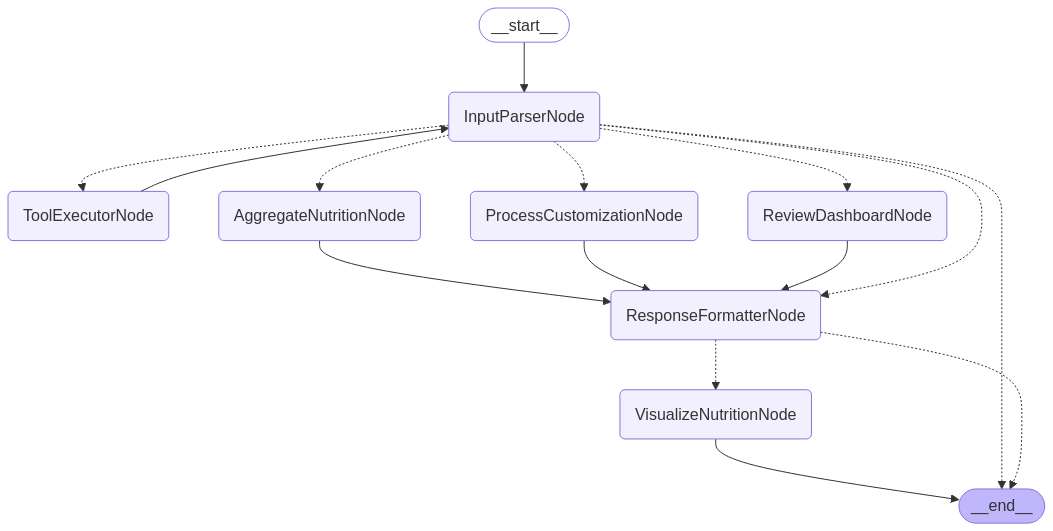

Graph visualization displayed.


In [85]:


### **Step 7: Graph Assembly & Compilation (Revised)**

# LangGraph Step 7: Graph Assembly & Compilation (Revised)

# --- Assume KitchenState, Nodes, Edges are defined ---
# from step1_state import KitchenState (Revised)
# from step3_5_nodes import input_parser_node, response_formatter_node # (Revised)
# from step3_tools import tool_executor_node
# from step4_actions import aggregate_nutrition_node, visualize_nutrition_node, review_dashboard_node, process_customization_node # (Revised/Added)
# from step5_routing import route_after_parsing, route_after_formatting # (Revised)

# --- Graph Assembly ---
graph_builder = StateGraph(KitchenState)

# Add Nodes (Ensure names match function names)
graph_builder.add_node("InputParserNode", input_parser_node)
graph_builder.add_node("ToolExecutorNode", tool_executor_node)
graph_builder.add_node("AggregateNutritionNode", aggregate_nutrition_node)
graph_builder.add_node("ResponseFormatterNode", response_formatter_node)
graph_builder.add_node("VisualizeNutritionNode", visualize_nutrition_node)
# ---> ADDED New Nodes <---
graph_builder.add_node("ReviewDashboardNode", review_dashboard_node)
graph_builder.add_node("ProcessCustomizationNode", process_customization_node)
# ---> END ADDITION <---

# Define Entry Point
graph_builder.add_edge(START, "InputParserNode")

# Define Conditional Edges from Parser
graph_builder.add_conditional_edges(
    "InputParserNode",
    route_after_parsing,
    {
        "ToolExecutorNode": "ToolExecutorNode",
        "AggregateNutritionNode": "AggregateNutritionNode",
        "ReviewDashboardNode": "ReviewDashboardNode", # ---> ADDED <---
        "ProcessCustomizationNode": "ProcessCustomizationNode", # ---> ADDED <---
        "ResponseFormatterNode": "ResponseFormatterNode", # Handles chat, errors, fetched data
        END: END
    }
)

# ---> REVISED: Edges After Tool Execution <---
# ToolExecutorNode output (ToolMessages) goes BACK to InputParserNode
# The parser will then route based on the tool name to the appropriate processing node
# or back to the LLM if the tool result needs interpretation.
graph_builder.add_edge("ToolExecutorNode", "InputParserNode")
# ---> END REVISION <---


# ---> ADDED: Edges After Processing Nodes <---
# After aggregation, review processing, or customization processing, format the response
graph_builder.add_edge("AggregateNutritionNode", "ResponseFormatterNode")
graph_builder.add_edge("ReviewDashboardNode", "ResponseFormatterNode")
graph_builder.add_edge("ProcessCustomizationNode", "ResponseFormatterNode")
# ---> END ADDITION <---

# After formatting, decide whether to visualize or end the turn
graph_builder.add_conditional_edges(
    "ResponseFormatterNode",
    route_after_formatting,
    {
        "VisualizeNutritionNode": "VisualizeNutritionNode",
        END: END
    }
)

# After visualization, the graph run ends for this turn
graph_builder.add_edge("VisualizeNutritionNode", END)


# Compile the graph
kitchen_assistant_graph = graph_builder.compile()

print("\n✅ LangGraph Step 7: Graph Compiled Successfully! (Revised Flow)")

# Visualize the updated graph
try:
    png_data = kitchen_assistant_graph.get_graph().draw_mermaid_png()
    display(Image(png_data))
    print("Graph visualization displayed.")
except Exception as e:
    print(f"\nGraph visualization failed: {e}")

In [86]:
# LangGraph Step 8: User Interface Integration (Revised)

# --- Assume KitchenState, Graph, transcribe_audio are defined ---
# from step1_state import KitchenState (Revised)
# from step6_graph import kitchen_assistant_graph (Revised)
# from step0_utils import transcribe_audio # Or wherever it's defined

# --- UI Simulation using ipywidgets ---

# Conversation state (global for this simple example)
# Reset state for UI interaction
conversation_state: KitchenState = {
    "messages": [], "user_input": None, "audio_file_path": None, "intent": None,
    "selected_recipe_id": None, "customization_request": None, "nutrition_query": None,
    "grounding_query": None, "current_recipe_details": None, "recipe_reviews": None,
    "ingredient_nutrition_list": None, "live_recipe_details": None, "nutritional_info": None,
    "processed_review_data": None, "customization_results": None, "grounding_results_formatted": None,
    "user_ingredients": [], "dietary_preferences": [],
    "needs_clarification": False, "finished": False, "last_assistant_response": None,
}

# Widgets
text_input = widgets.Textarea(description="You:", layout={'width': '90%', 'height': '80px'}) # Adjusted height
text_submit_button = widgets.Button(description="Send Text")
# Define voice options (use actual paths accessible to your environment)
default_voice_path = "/kaggle/input/some-audio-dataset/audio.ogg" # Example placeholder
voice_options = [
    ("Select Voice...", None),
    # Add paths to your actual .ogg or .wav files here
    # ("Pizza Search (Simulated)", "path/to/your/pizza_search.ogg"),
]
# Filter options if needed
# valid_voice_options = [(name, path) for name, path in voice_options if path is None or os.path.exists(path)]
# voice_dropdown = widgets.Dropdown(options=valid_voice_options, description="Voice:")
voice_dropdown = widgets.Dropdown(options=voice_options, description="Voice:") # Using original for now
voice_submit_button = widgets.Button(description="Process Voice")

# ---> REVISED: Output Area for Chat History <---
chat_history_output = widgets.Output(layout={
    'border': '1px solid black',
    'height': '400px',
    'overflow_y': 'scroll',
    'width': '90%'
})

# ---> REVISED: Separate Output for Debug Info <---
debug_output = widgets.Output(layout={
    'border': '1px solid blue',
    'height': '150px', # Increased height slightly
    'overflow_y': 'scroll',
    'width': '90%'
})

# Display initial welcome message in the chat history
with chat_history_output:
    display(Markdown("**Assistant:** Welcome! Ask me about recipes, ingredients, or nutrition."))
    # Optionally add to state if needed for graph context on first turn
    # conversation_state["messages"].append(AIMessage(content="Welcome! Ask me about recipes, ingredients, or nutrition."))
    # conversation_state["last_assistant_response"] = "Welcome! Ask me about recipes, ingredients, or nutrition."


# --- Interaction Logic (Revised for better display and Markdown) ---
def run_graph_and_display(initial_state_update: Dict[str, Any]):
    global conversation_state

    # 1. Prepare input for the graph
    current_messages = list(conversation_state.get("messages", []))
    if "messages" in initial_state_update:
        # Don't add the human message here yet, add it to the display first
        pass

    input_for_graph = conversation_state.copy()
    input_for_graph.update(initial_state_update)
    # Pass the *existing* history plus the *new* human message to the graph
    input_for_graph["messages"] = current_messages + initial_state_update.get("messages", [])
    input_for_graph["intent"] = None
    input_for_graph["last_assistant_response"] = None
    input_for_graph["nutritional_info"] = None # Clear previous results
    input_for_graph["processed_review_data"] = None
    input_for_graph["customization_results"] = None
    input_for_graph["live_recipe_details"] = None
    input_for_graph["needs_clarification"] = False
    # Keep context like selected_recipe_id

    # ---> REVISED: Display Logic - Append latest interaction <---
    user_input_text = initial_state_update.get("user_input", "")
    with chat_history_output:
        # Display the user's input for this turn
        display(Markdown(f"**You:** {user_input_text}"))
        # Display a thinking indicator
        thinking_output = widgets.Output()
        with thinking_output:
             display(Markdown("**Assistant:** Thinking..."))
        display(thinking_output)
    # ---> END REVISION <---

    # 2. Stream graph execution (or use invoke)
    final_state_after_run = None
    assistant_response_to_display = "..." # Default thinking message
    error_occurred = None

    # Clear previous debug info
    with debug_output:
        clear_output(wait=True)
        print("--- Running Graph ---")

    try:
        # Use stream to observe intermediate steps in debug output
        for step_state in kitchen_assistant_graph.stream(input_for_graph, {"recursion_limit": 25}):
            node_name = list(step_state.keys())[0]
            current_state_snapshot = step_state[node_name]

            # --- Debugging Output ---
            with debug_output:
                 # print(f"\n--- Step: {node_name} ---") # Keep adding steps
                 # Simple print of node name is often enough
                 print(f"-> {node_name}")
                 # Optionally print more details like intent, last message etc.
                 # print(f"  Intent: {current_state_snapshot.get('intent')}")
                 # last_msg = current_state_snapshot.get('messages', [])[-1] if current_state_snapshot.get('messages') else None
                 # if last_msg: print(f"  Last Msg: {type(last_msg).__name__}")
            # --- End Debugging ---

            # Update global state progressively
            conversation_state.update(current_state_snapshot)
            final_state_after_run = conversation_state # Keep track of the latest full state

            if conversation_state.get("finished", False):
                with debug_output: print("--- Finished flag set, ending stream early. ---")
                break

        # After the stream finishes (or breaks)
        if final_state_after_run:
            conversation_state.update(final_state_after_run) # Ensure final state is captured
            assistant_response_to_display = conversation_state.get("last_assistant_response", "Okay, what next?")
            if conversation_state.get("finished"):
                 assistant_response_to_display = conversation_state.get("last_assistant_response", "Goodbye!")
        else:
             assistant_response_to_display = "Something went wrong during processing (no final state)."
             error_occurred = "No final state returned from graph."
             conversation_state["last_assistant_response"] = assistant_response_to_display
             if "messages" not in conversation_state: conversation_state["messages"] = []
             conversation_state["messages"].append(AIMessage(content=assistant_response_to_display))


    except Exception as e:
        assistant_response_to_display = f"An error occurred: {e}"
        error_occurred = str(e)
        print(f"ERROR during graph execution: {e}")
        import traceback
        with debug_output: # Print traceback to debug area
            traceback.print_exc()
        conversation_state["last_assistant_response"] = assistant_response_to_display
        if "messages" not in conversation_state: conversation_state["messages"] = []
        # Add error as AI message to history
        conversation_state["messages"].append(AIMessage(content=f"Error: {e}"))

    # 3. Display the final AI response for this turn
    # ---> REVISED: Display Logic - Update thinking message with final response <---
    with chat_history_output:
        thinking_output.clear_output() # Remove "Thinking..."
        if assistant_response_to_display:
            display(Markdown(f"**Assistant:**\n\n{assistant_response_to_display}"))
        elif error_occurred:
             display(Markdown(f"**Assistant:** Sorry, an error occurred: {error_occurred}"))
        else:
             display(Markdown(f"**Assistant:** (No response content generated)"))
        # Add a separator for clarity
        display(Markdown("---"))
    # ---> END REVISION <---

    # 4. Visualization (Matplotlib) is handled INSIDE the graph by VisualizeNutritionNode
    # and should appear in the standard cell output area below the widgets.

# --- Event Handlers (No changes needed here, they call the revised run_graph_and_display) ---
def on_text_submit(b):
    user_text = text_input.value
    if not user_text: return
    initial_update = {
        "user_input": user_text,
        "messages": [HumanMessage(content=user_text)], # Pass the new message
        "finished": False
        }
    text_input.value = "" # Clear input
    run_graph_and_display(initial_update)

def on_voice_submit(b):
     selected_file = voice_dropdown.value
     if not selected_file:
         with chat_history_output: display(Markdown("**Assistant:** Please select a voice file.\n\n---")); return
     if not os.path.exists(selected_file):
          with chat_history_output: display(Markdown(f"**Assistant:** Error - Voice file not found: {selected_file}\n\n---")); return

     # Display processing message in chat
     with chat_history_output:
         display(Markdown(f"*(Processing voice file: {os.path.basename(selected_file)}...)*"))
         thinking_output = widgets.Output()
         with thinking_output: display(Markdown("**Assistant:** Transcribing..."))
         display(thinking_output)

     transcribed_text = "Error: Transcription setup failed."
     # ... (Keep the transcription logic from your original Step 7) ...
     try:
         google_creds = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
         openai_key = os.getenv("OPENAI_API_KEY")

         if google_creds and os.path.exists(google_creds):
              try:
                  import io
                  from google.cloud import speech
                  print("Attempting transcription with Google Cloud Speech...")
                  # Ensure transcribe_audio function is defined/imported
                  transcribed_text = transcribe_audio(service="google", file_path=selected_file, credentials_path=google_creds)
              except ImportError:
                   print("Google Cloud Speech library not installed.")
                   transcribed_text = "Error: Google Speech library missing."
              except Exception as google_err:
                   print(f"Google transcription failed: {google_err}")
                   transcribed_text = f"Error: Google transcription failed - {google_err}"
         elif openai_key:
              try:
                  from openai import OpenAI
                  print("Attempting transcription with OpenAI Whisper...")
                  # Ensure transcribe_audio function is defined/imported
                  transcribed_text = transcribe_audio(service="openai", file_path=selected_file, api_key=openai_key)
              except ImportError:
                   print("OpenAI library not installed.")
                   transcribed_text = "Error: OpenAI library missing."
              except Exception as openai_err:
                   print(f"OpenAI transcription failed: {openai_err}")
                   transcribed_text = f"Error: OpenAI transcription failed - {openai_err}"
         else:
              print("Neither Google Credentials nor OpenAI API Key found.")
              transcribed_text = "Error: No transcription service configured."
     except NameError:
          print("ERROR: transcribe_audio function not defined.")
          transcribed_text = "Error: Transcription function missing."
     except Exception as e:
          print(f"Unexpected error during transcription setup: {e}")
          transcribed_text = f"Error: Transcription failed unexpectedly - {e}"


     # Clear transcribing message
     with chat_history_output:
         thinking_output.clear_output()

     if "Error:" in transcribed_text:
          with chat_history_output: display(Markdown(f"**Assistant:** Transcription failed - {transcribed_text}\n\n---"))
          return

     # Display transcribed text as user input before running graph
     with chat_history_output:
         display(Markdown(f"**You (from voice):** {transcribed_text}"))

     initial_update = {
         "user_input": transcribed_text,
         "messages": [HumanMessage(content=transcribed_text)], # Pass the new message
         "audio_file_path": selected_file,
         "finished": False
     }
     voice_dropdown.value = None # Reset dropdown
     run_graph_and_display(initial_update) # Run graph with transcribed text

# Assign callbacks
text_submit_button.on_click(on_text_submit)
voice_submit_button.on_click(on_voice_submit)

# Display Widgets
print("--- Kitchen Assistant Interface ---")

# ---> REVISED: Display layout <---
# display(widgets.VBox([
#     widgets.HTML("<b>Enter request via text or select voice file:</b>"),
#     widgets.HBox([text_input, text_submit_button]), # Text input and button side-by-side
#     widgets.HBox([voice_dropdown, voice_submit_button]), # Voice input and button side-by-side
#     widgets.HTML("<hr><b>Conversation:</b>"),
#     chat_history_output, # Use the dedicated chat history output
#     widgets.HTML("<hr><b>Debug Log (Graph Steps):</b>"),
#     debug_output
# ]))

print("✅ LangGraph Step 8: UI Integration Setup Complete (Revised)")

--- Kitchen Assistant Interface ---
✅ LangGraph Step 8: UI Integration Setup Complete (Revised)


In [87]:
# LangGraph Step 9: Chat Helper Function & JSON Output (Revised - Cleaner Markdown Display)



# Utility to suppress stdout
@contextlib.contextmanager
def suppress_stdout():
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout

# --- Chat Helper with Cleaner Markdown Output ---
def chat_with_assistant(user_msg: str, state: dict) -> dict:
    """
    Runs a turn of the conversation with the LangGraph agent.
    Displays ONLY the user's input and the AI's final response for this turn,
    formatted as Markdown.
    Returns the updated state dictionary containing the full message history.
    """
    if not state:
        state = {"messages": []}
    elif "messages" not in state:
        state["messages"] = []

    # Prepare input state for the graph
    current_messages = state.get("messages", [])
    input_messages = current_messages + [HumanMessage(content=user_msg)]

    input_for_graph = state.copy()
    input_for_graph["messages"] = input_messages
    input_for_graph["user_input"] = user_msg
    input_for_graph["finished"] = False
    # Clear fields that the graph should determine
    input_for_graph["intent"] = None
    input_for_graph["last_assistant_response"] = None
    input_for_graph["nutritional_info"] = None
    input_for_graph["processed_review_data"] = None
    input_for_graph["customization_results"] = None
    input_for_graph["live_recipe_details"] = None
    input_for_graph["needs_clarification"] = False

    final_state = {}
    print(f"\n--- Invoking Graph for: '{user_msg[:50]}...' ---") # Keep invocation message

    # ---> ADDED: Suppress stdout during graph execution <---
    with suppress_stdout():
        try:
            # Invoke the graph
            final_state = kitchen_assistant_graph.invoke(input_for_graph, {"recursion_limit": 25})
        except Exception as e:
            # Print error outside the suppressed block if invoke fails
            print(f"ERROR during graph invocation: {e}")
            import traceback
            traceback.print_exc()
            # Create minimal error state to return
            final_state = input_for_graph.copy()
            error_content = f"Sorry, an error occurred: {e}"
            final_state["messages"] = final_state.get("messages", []) + [AIMessage(content=error_content)]
            final_state["last_assistant_response"] = error_content
            final_state["intent"] = "error"
    # ---> END ADDITION <---

    print("--- Graph Invocation Complete ---") # Keep completion message

    # --- Display ONLY the final User/AI interaction for this turn using Markdown ---
    ai_response_text = final_state.get("last_assistant_response", None)

    if not ai_response_text and final_state.get("messages"):
         last_ai = next((msg for msg in reversed(final_state["messages"]) if isinstance(msg, AIMessage) and getattr(msg, 'content', None)), None)
         if last_ai:
             ai_response_text = last_ai.content

    # Display the user message for this turn
    display(Markdown(f"**🧑 You:**\n\n{user_msg}"))

    # Display the AI response for this turn
    if ai_response_text:
        display(Markdown(f"**🤖 AI:**\n\n{ai_response_text}"))
    else:
        display(Markdown("**🤖 AI:**\n\n(No response content generated or an error occurred)"))
        # print(f"Debug: Final state keys: {final_state.keys()}") # Optional debug

    # Ensure last_assistant_response is actually in the returned state dict
    if "last_assistant_response" not in final_state:
        final_state["last_assistant_response"] = ai_response_text if ai_response_text else "(Error or no response)"

    return final_state

# --- JSON Output Function (No changes needed here) ---
def get_assistant_response_json(user_msg: str, state: dict) -> str:
    """
    Runs a turn of the conversation and returns the key information
    (user input, AI response, final state summary) as a JSON string.
    """
    if not state:
        state = {"messages": []}
    elif "messages" not in state:
        state["messages"] = []

    # Prepare input state
    current_messages = state.get("messages", [])
    input_messages = current_messages + [HumanMessage(content=user_msg)]
    input_for_graph = state.copy()
    input_for_graph["messages"] = input_messages
    input_for_graph["user_input"] = user_msg
    input_for_graph["finished"] = False
    input_for_graph["intent"] = None
    input_for_graph["last_assistant_response"] = None
    # Clear other transient fields

    final_state = {}
    error_message = None
    # print(f"\n--- Invoking Graph for JSON Output: '{user_msg[:50]}...' ---") # Keep this print ?
    with suppress_stdout(): # Suppress internal prints for this function
        try:
            final_state = kitchen_assistant_graph.invoke(input_for_graph, {"recursion_limit": 25})
        except Exception as e:
            # print(f"ERROR during graph invocation for JSON: {e}") # Keep this print ?
            error_message = str(e)
            final_state = input_for_graph.copy()
            final_state["intent"] = "error"
            final_state["last_assistant_response"] = f"Error: {e}"

    # print("--- Graph Invocation Complete (JSON) ---") # Keep this print ?

    # Extract relevant info
    ai_response_text = final_state.get("last_assistant_response", None)
    if not ai_response_text and final_state.get("messages"):
         last_ai = next((msg for msg in reversed(final_state["messages"]) if isinstance(msg, AIMessage) and getattr(msg, 'content', None)), None)
         if last_ai: ai_response_text = last_ai.content

    state_summary = {
        "intent": final_state.get("intent"),
        "selected_recipe_id": final_state.get("selected_recipe_id"),
        "needs_clarification": final_state.get("needs_clarification"),
        "finished": final_state.get("finished"),
        "has_recipe_details": bool(final_state.get("current_recipe_details")),
        "has_live_details": bool(final_state.get("live_recipe_details")),
        "has_reviews": bool(final_state.get("recipe_reviews")),
        "has_processed_reviews": bool(final_state.get("processed_review_data")),
        "has_nutrition": bool(final_state.get("nutritional_info")),
        "has_customization": bool(final_state.get("customization_results")),
    }

    output_data = {
        "user_input": user_msg,
        "ai_response": ai_response_text if not error_message else None,
        "error": error_message,
        "state_summary": state_summary,
        # "message_history": [msg.dict() for msg in final_state.get("messages", [])] # Optional
    }

    try:
        return json.dumps(output_data, indent=2, default=str)
    except TypeError as e:
        # print(f"Error serializing output to JSON: {e}") # Keep this print ?
        return json.dumps({"error": "Failed to serialize final state to JSON.", "details": str(e)}, indent=2)


print("✅ LangGraph Step 9: Chat Helper Function & JSON Output Defined (Revised Display)")

✅ LangGraph Step 9: Chat Helper Function & JSON Output Defined (Revised Display)


In [88]:
state = {}  # Initialize empty state first


In [91]:
state = chat_with_assistant("Hello, what can you do?", state)



--- Invoking Graph for: 'Hello, what can you do?...' ---


/home/snowholt/venv/analytic/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:367: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


--- Graph Invocation Complete ---


**🧑 You:**

Hello, what can you do?

**🤖 AI:**

Hello! I can help you find recipes, give you details about specific recipes, find ratings and reviews, provide nutrition information, and even customize recipes to fit your needs.

What are you in the mood for today? Do you have a specific recipe in mind, or would you like me to suggest some?

In [92]:
state = chat_with_assistant("Find me vegeterian soup recipes and tag the recipes. 5 recipes", state)



--- Invoking Graph for: 'Find me vegeterian soup recipes and tag the recipe...' ---
--- Graph Invocation Complete ---


**🧑 You:**

Find me vegeterian soup recipes and tag the recipes. 5 recipes

**🤖 AI:**

I found five vegetarian soup recipes:

1.  **Yogurt and cucumber soup** (Thai, 210 minutes, ID: 128684)
2.  **Soupe au pistou from nice** (French, 40 minutes, ID: 184537)
3.  **Greek barley soup** (Other, 75 minutes, ID: 37706)
4.  **Newfoundland style pea soup with doughboys dumplings** (Other, 270 minutes, ID: 332086)
5.  **Broccoli and cheese potato soup** (Other, 40 minutes, ID: 104304)

Would you like more details on any of these recipes?

In [93]:
state = chat_with_assistant("I like to know about third recipe in the list", state)



--- Invoking Graph for: 'I like to know about third recipe in the list...' ---
--- Graph Invocation Complete ---


**🧑 You:**

I like to know about third recipe in the list

**🤖 AI:**

📊 Recipe Dashboard for **greek barley soup** (ID: 37706)
*Source: internal database*
_this is one soup i love to make in the fall, filling and very comforting._

---
| Metric          | Value                     |
|-----------------|---------------------------|
| 🌶️🌶️ Difficulty    | Medium                |
| ⏱️ Total Time    | 75 minutes         |
| 🥕 Ingredients | 16 count             |
| 🔢 Steps         | 10 count               |
---

**Ingredients:**
- unsalted butter onions garlic fresh parsley fresh marjoram fresh rosemary vegetable stock pearl barley carrots potato bay leaf table salt ground black pepper milk egg yolks parmesan cheese

**Steps:**
heat the butter in a large pot over medium heat add the onions and saut until soft and translucent , about 10 minutes add the garlic , parsley , marjoram , and rosemary and saut for 1 minute add the stock , barley , carrots , if using , potato , bay leaf , salt , and pepper bring to a boil , reduce the heat to low , cover , and simmer until the barley is nearly tender , about 45 minutes add the milk and heat through remove from the heat gradually stir 1 cup of the soup into the egg yolks , then stir the yolk mixture and parmesan into the soup return to low heat and stir until thickened , about 3 minutes serve warm

In [94]:
state = chat_with_assistant("Show the recipe reviews", state)



--- Invoking Graph for: 'Show the recipe reviews...' ---
--- Graph Invocation Complete ---


**🧑 You:**

Show the recipe reviews

**🤖 AI:**

⭐ Reviews Dashboard for **greek barley soup** (ID: 37706)
**Overall Rating:** ⭐⭐⭐⭐⭐ (5.0/5.0)
---
**Rating Breakdown:**
- ⭐⭐⭐⭐⭐ : 2 ratings (100%)
- ⭐⭐⭐⭐ : 0 ratings (0%)
- ⭐⭐⭐ : 0 ratings (0%)
- ⭐⭐ : 0 ratings (0%)
- ⭐ : 0 ratings (0%)

**Sentiment:**
- 😊 Mostly Positive (Pos: 2, Neg: 0, Neu: 0)

**Recent Reviews:**

- ⭐⭐⭐⭐⭐ 😊 *(2018-12-09)*
> "Delicious! Pretty quick, too."

- ⭐⭐⭐⭐⭐ 😊 *(2003-08-30)*
> "My toddler and I both loved this soup. Filling wihout being stodgy. Used thyme instead of rosemary which made little difference. I also scaled the recipe down to a half batch without problems. Thanks ..."


--- Invoking Graph for: 'get nutrition info of this recipe...' ---


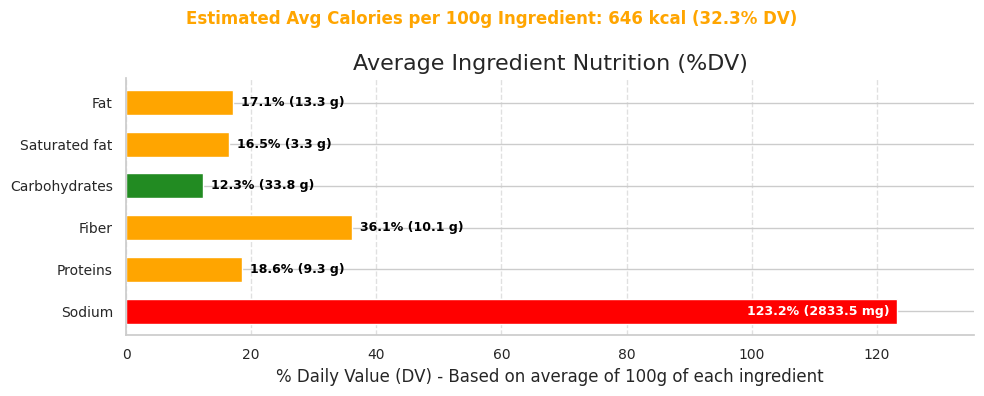

--- Graph Invocation Complete ---


**🧑 You:**

get nutrition info of this recipe

**🤖 AI:**

Here's the approximate average nutrition per 100g for ingredients in **greek barley soup**:

- Calories: 645.9 kcal
- Fat: 13.3 g
- Saturated fat: 3.3 g
- Carbohydrates: 33.8 g
- Fiber: 10.1 g
- Proteins: 9.3 g
- Sodium: 2833.5 mg

(Note: Based on average of 16 ingredients with available data from USDA FDC. Actual recipe nutrition will vary.)

In [96]:
state = chat_with_assistant("get nutrition info of this recipe", state)


In [ ]:
state = chat_with_assistant("yes it is that same recipe", state)


In [97]:
state = chat_with_assistant("make this recipe more healthy for low fat diet", state)



--- Invoking Graph for: 'make this recipe more healthy for low fat diet...' ---
--- Graph Invocation Complete ---


**🧑 You:**

make this recipe more healthy for low fat diet

**🤖 AI:**

🛠️ Recipe Customization Suggestions for **greek barley soup** (ID: 37706)

Suggestions for making recipe 37706 'make it low fat':
- Reduce added fats like butter or oil where possible.
- Use low-fat dairy alternatives.
- Consider adding more vegetables for volume and nutrients.

In [98]:
state = chat_with_assistant("What's a good substitute for egg yolks", state)



--- Invoking Graph for: 'What's a good substitute for egg yolks...' ---
--- Graph Invocation Complete ---


**🧑 You:**

What's a good substitute for egg yolks

**🤖 AI:**

Based on a quick search, good substitutes for egg yolks in soup, especially when trying to reduce fat or cholesterol, include:

*   **Cornstarch:** Mix 1 tablespoon of cornstarch with 2 tablespoons of water for each egg yolk. This will help thicken the soup.
*   **Arrowroot powder:** Similar to cornstarch, use 1 tablespoon with 2 tablespoons of water per yolk.
*   **Silken tofu:** Puree silken tofu until smooth and use about 1/4 cup to replace 1-2 yolks. This adds creaminess.
*   **Mashed potato or other cooked vegetables:** Can add body and thickness to the soup.
*   **Cashew cream:** Soak raw cashews in hot water, then blend until smooth. Use this for a very creamy texture.
*   **Plain yogurt or Greek yogurt:** Can add a tangy flavor and creaminess. Be careful not to boil the soup after adding yogurt to prevent curdling.

The best choice depends on the desired flavor and texture of the soup.

In [99]:
state["messages"]

[HumanMessage(content='Hello, what can you do?', additional_kwargs={}, response_metadata={}, id='db95a077-244b-40fa-bdc7-ea0095593623'),
 AIMessage(content='Hello! I can help you find recipes, give you details about specific recipes, find ratings and reviews, provide nutrition information, and even customize recipes to fit your needs.\n\nWhat are you in the mood for today? Do you have a specific recipe in mind, or would you like me to suggest some?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-8d266414-9ec1-424e-8b08-a454d5e0fd3a-0', usage_metadata={'input_tokens': 2495, 'output_tokens': 63, 'total_tokens': 2558, 'input_token_details': {'cache_read': 0}}),
 AIMessage(content='Hello! I can help you find recipes, give you details about specific recipes, find ratings and reviews, provide nutrition information, and even customize recipes to fi